## The goal of this notebook is to select the most relevant features to predict zhvi (and/or change in) and zri (and/or change in)

In [196]:
from fetch_other_data import get_fed_fund, get_mtg_rate, get_market, get_census, get_irs
from fetch_zillow_data import get_zri, get_zhvi

import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import visuals as vs
%matplotlib inline

from scipy import stats
from scipy.special import boxcox1p, boxcox
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

### Grab zhvi data

In [2]:
%%time
zhvi = get_zhvi(update = False)

Wall time: 47min 10s


### Grab data from other sources

In [188]:
%%time
mortgage_rate, mortgage_rate_annual = get_mtg_rate(False)

Updated by: freddiemac
date range: 1971-01-01 00:00:00 to 2018-04-01 00:00:00
Wall time: 52.1 ms


In [189]:
%%time
fed_rate, fed_rate_annual = get_fed_fund(False)

Updated by: Quandl
date range: 1954-07-01 00:00:00 to 2018-04-01 00:00:00
Wall time: 484 ms


In [190]:
%%time
market, market_annual = get_market(False)

Updated by: Yahoo! Finance
date range: 1985-01-29 00:00:00 to 2018-05-04 00:00:00
Wall time: 85.8 ms


In [191]:
%%time
census = get_census()

Updated by: American Community Survey (US Census Bureau)
Wall time: 479 ms


In [197]:
%%time
#irs_zip_summary, irs_state_summary, irs_zip_MMScaler = get_irs(False) #why didn't this work?! Worked in IDLE
irs_zip_summary, irs_state_summary = get_irs(False)

Updated by: IRS


E:\WinUser\Documents\Python Code\Real Estate Intelligence\For Github\fetch_other_data.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  state_summary = combined[combined['ZIPCODE'] == '00000']
E:\WinUser\Documents\Python Code\Real Estate Intelligence\For Github\fetch_other_data.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\WinUser\Documents\Python Code\Real Estate Intelligence\For Github\fetch_other_data.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Wall time: 57.2 s


E:\WinUser\Documents\Python Code\Real Estate Intelligence\For Github\fetch_other_data.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  state_summary['avg SW z'] = (state_summary['avg SW'] - state_summary[state_summary['year'] == max(years)]['avg SW'].mean()) / state_summary[state_summary['year'] == max(years)]['avg SW'].std()
E:\WinUser\Documents\Python Code\Real Estate Intelligence\For Github\fetch_other_data.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  state_summary['avg OI z'] = (state_summary['avg OI'] - state_summary[stat

### Manipulate mortgage rate data

In [4]:
#30-year mortgage rate offsets
mortgage_rate['30 FRM Rate 1'] = mortgage_rate['30 FRM Rate'].shift(1)
mortgage_rate['30 FRM Rate 6'] = mortgage_rate['30 FRM Rate'].shift(6)
mortgage_rate['30 FRM Rate 12'] = mortgage_rate['30 FRM Rate'].shift(12)
mortgage_rate['30 FRM Rate 24'] = mortgage_rate['30 FRM Rate'].shift(24)

mortgage_rate['30 FRM Rate pct_change'] = mortgage_rate['30 FRM Rate'].pct_change()
mortgage_rate['30 FRM Rate pct_change 1'] = mortgage_rate['30 FRM Rate pct_change'].shift(1)
mortgage_rate['30 FRM Rate pct_change 6'] = mortgage_rate['30 FRM Rate pct_change'].shift(6)
mortgage_rate['30 FRM Rate pct_change 12'] = mortgage_rate['30 FRM Rate pct_change'].shift(12)
mortgage_rate['30 FRM Rate pct_change 24'] = mortgage_rate['30 FRM Rate pct_change'].shift(24)

mortgage_rate.head(20)

year  30 FRM Rate  30 FRM Pts  15 FRM Rate  15 FRM Pts  \
Date                                                                   
1971-01-01  1971.0          NaN         NaN          NaN         NaN   
1971-02-01  1971.0          NaN         NaN          NaN         NaN   
1971-03-01  1971.0          NaN         NaN          NaN         NaN   
1971-04-01  1971.0         7.31         NaN          NaN         NaN   
1971-05-01  1971.0         7.43         NaN          NaN         NaN   
1971-06-01  1971.0         7.53         NaN          NaN         NaN   
1971-07-01  1971.0         7.60         NaN          NaN         NaN   
1971-08-01  1971.0         7.70         NaN          NaN         NaN   
1971-09-01  1971.0         7.69         NaN          NaN         NaN   
1971-10-01  1971.0         7.63         NaN          NaN         NaN   
1971-11-01  1971.0         7.55         NaN          NaN         NaN   
1971-12-01  1971.0         7.48         NaN          NaN         NaN   
1972-01-01  1972.0         7.44         1.0          NaN         NaN   
1972-02-01  1972.0         7.32         0.9          NaN         NaN   
1972-03-01  1972.0         7.29         0.9          NaN         NaN   
1972-04-01  1972.0         7.29         0.9          NaN         NaN   
1972-05-01  1972.0         7.37         0.9          NaN         NaN   
1972-06-01  1972.0         7.37         0.9          NaN         NaN   
1972-07-01  1972.0         7.40         0.9          NaN         NaN   
1972-08-01  1972.0         7.40         0.9          NaN         NaN   

            5-1 ARM Rate  5-1 ARM Margin  30 FRM Rate 1  30 FRM Rate 6  \
Date                                                                     
1971-01-01           NaN             NaN            NaN            NaN   
1971-02-01           NaN             NaN            NaN            NaN   
1971-03-01           NaN             NaN            NaN            NaN   
1971-04-01           NaN             NaN            NaN            NaN   
1971-05-01           NaN             NaN           7.31            NaN   
1971-06-01           NaN             NaN           7.43            NaN   
1971-07-01           NaN             NaN           7.53            NaN   
1971-08-01           NaN             NaN           7.60            NaN   
1971-09-01           NaN             NaN           7.70            NaN   
1971-10-01           NaN             NaN           7.69           7.31   
1971-11-01           NaN             NaN           7.63           7.43   
1971-12-01           NaN             NaN           7.55           7.53   
1972-01-01           NaN             NaN           7.48           7.60   
1972-02-01           NaN             NaN           7.44           7.70   
1972-03-01           NaN             NaN           7.32           7.69   
1972-04-01           NaN             NaN           7.29           7.63   
1972-05-01           NaN             NaN           7.29           7.55   
1972-06-01           NaN             NaN           7.37           7.48   
1972-07-01           NaN             NaN           7.37           7.44   
1972-08-01           NaN             NaN           7.40           7.32   

            30 FRM Rate 12  30 FRM Rate 24  30 FRM Rate pct_change  \
Date                                                                 
1971-01-01             NaN             NaN                     NaN   
1971-02-01             NaN             NaN                     NaN   
1971-03-01             NaN             NaN                     NaN   
1971-04-01             NaN             NaN                     NaN   
1971-05-01             NaN             NaN                0.016416   
1971-06-01             NaN             NaN                0.013459   
1971-07-01             NaN             NaN                0.009296   
1971-08-01             NaN             NaN                0.013158   
1971-09-01             NaN             NaN               -0.001299   
1971-10-01             NaN    

### Manipulate fed rate data

In [5]:
fed_rate['Fed Rate 1'] = fed_rate['Fed Rate'].shift(1)
fed_rate['Fed Rate 6'] = fed_rate['Fed Rate'].shift(6)
fed_rate['Fed Rate 12'] = fed_rate['Fed Rate'].shift(12)
fed_rate['Fed Rate 24'] = fed_rate['Fed Rate'].shift(24)

fed_rate['Fed Rate pct_change'] = fed_rate['Fed Rate'].pct_change()
fed_rate['Fed Rate pct_change 1'] = fed_rate['Fed Rate pct_change'].shift(1)
fed_rate['Fed Rate pct_change 6'] = fed_rate['Fed Rate pct_change'].shift(6)
fed_rate['Fed Rate pct_change 12'] = fed_rate['Fed Rate pct_change'].shift(12)
fed_rate['Fed Rate pct_change 24'] = fed_rate['Fed Rate pct_change'].shift(24)

fed_rate.head(20)

Fed Rate  year  Fed Rate 1  Fed Rate 6  Fed Rate 12  Fed Rate 24  \
1954-07-01      0.80  1954         NaN         NaN          NaN          NaN   
1954-08-01      1.22  1954        0.80         NaN          NaN          NaN   
1954-09-01      1.06  1954        1.22         NaN          NaN          NaN   
1954-10-01      0.85  1954        1.06         NaN          NaN          NaN   
1954-11-01      0.83  1954        0.85         NaN          NaN          NaN   
1954-12-01      1.28  1954        0.83         NaN          NaN          NaN   
1955-01-01      1.39  1955        1.28        0.80          NaN          NaN   
1955-02-01      1.29  1955        1.39        1.22          NaN          NaN   
1955-03-01      1.35  1955        1.29        1.06          NaN          NaN   
1955-04-01      1.43  1955        1.35        0.85          NaN          NaN   
1955-05-01      1.43  1955        1.43        0.83          NaN          NaN   
1955-06-01      1.64  1955        1.43        1.28          NaN          NaN   
1955-07-01      1.68  1955        1.64        1.39         0.80          NaN   
1955-08-01      1.96  1955        1.68        1.29         1.22          NaN   
1955-09-01      2.18  1955        1.96        1.35         1.06          NaN   
1955-10-01      2.24  1955        2.18        1.43         0.85          NaN   
1955-11-01      2.35  1955        2.24        1.43         0.83          NaN   
1955-12-01      2.48  1955        2.35        1.64         1.28          NaN   
1956-01-01      2.45  1956        2.48        1.68         1.39          NaN   
1956-02-01      2.50  1956        2.45        1.96         1.29          NaN   

            Fed Rate pct_change  Fed Rate pct_change 1  Fed Rate pct_change 6  \
1954-07-01                  NaN                    NaN                    NaN   
1954-08-01             0.525000                    NaN                    NaN   
1954-09-01            -0.131148               0.525000                    NaN   
1954-10-01            -0.198113              -0.131148                    NaN   
1954-11-01            -0.023529              -0.198113                    NaN   
1954-12-01             0.542169              -0.023529                    NaN   
1955-01-01             0.085938               0.542169                    NaN   
1955-02-01            -0.071942               0.085938               0.525000   
1955-03-01             0.046512              -0.071942              -0.131148   
1955-04-01             0.059259               0.046512              -0.198113   
1955-05-01             0.000000               0.059259              -0.023529   
1955-06-01             0.146853               0.000000               0.542169   
1955-07-01             0.024390               0.146853               0.085938   
1955-08-01             0.166667               0.024390              -0.071942   
1955-09-01             0.112245               0.166667               0.046512   
1955-10-01             0.027523               0.112245               0.059259   
1955-11-01             0.049107               0.027523               0.000000   
1955-12-01             0.055319               0.049107               0.146853   
1956-01-01            -0.012097               0.055319               0.024390   
1956-02-01             0.020408              -0.012097               0.166667   

            Fed Rate pct_change 12  Fed Rate pct_change 24  
1954-07-01                     NaN                     NaN  
1954-08-01                     NaN                     NaN  
1954-09-01                     NaN                     NaN  
1954-10-01                     NaN                     NaN  
1954-11-01                     NaN                     NaN  
1954-12-01                     NaN                     NaN  
1955-01-01                     NaN                     NaN  
1955-02-01                     NaN                     NaN  
1955-03-01                     NaN                     NaN  
1955-04-01         

### Manipulate market data (Dow, Nasdaq, S&P)

In [6]:
#let's do a MA instead of price at specific point
market_ma = market[['Adj Close_d', 'Volume_d', 'Adj Close_n', 'Volume_n', 'Adj Close_s', 'Volume_s']]
market_ma['d_tot'] = market_ma['Adj Close_d'] * market_ma['Volume_d']
market_ma['n_tot'] = market_ma['Adj Close_n'] * market_ma['Volume_n']
market_ma['s_tot'] = market_ma['Adj Close_s'] * market_ma['Volume_s']
market_ma['month'] = market_ma.index.map(lambda x: datetime.datetime(x.year, x.month, 1))
market_ma_groups = market_ma.groupby('month')['d_tot', 'n_tot', 's_tot', 'Volume_d', 'Volume_n', 'Volume_s'].sum()
market_ma_groups['D_MA'] = market_ma_groups['d_tot'] / market_ma_groups['Volume_d']
market_ma_groups['N_MA'] = market_ma_groups['n_tot'] / market_ma_groups['Volume_n']
market_ma_groups['S_MA'] = market_ma_groups['s_tot'] / market_ma_groups['Volume_s']

#Dow
market_ma_groups['D_MA 1'] = market_ma_groups['D_MA'].shift(1)
market_ma_groups['D_MA 6'] = market_ma_groups['D_MA'].shift(6)
market_ma_groups['D_MA 12'] = market_ma_groups['D_MA'].shift(12)
market_ma_groups['D_MA 24'] = market_ma_groups['D_MA'].shift(24)

market_ma_groups['D_MA pct_change'] = market_ma_groups['D_MA'].pct_change()
market_ma_groups['D_MA pct_change 1'] = market_ma_groups['D_MA pct_change'].shift(1)
market_ma_groups['D_MA pct_change 6'] = market_ma_groups['D_MA pct_change'].shift(6)
market_ma_groups['D_MA pct_change 12'] = market_ma_groups['D_MA pct_change'].shift(12)
market_ma_groups['D_MA pct_change 24'] = market_ma_groups['D_MA pct_change'].shift(24)

#S&P
market_ma_groups['S_MA 1'] = market_ma_groups['S_MA'].shift(1)
market_ma_groups['S_MA 6'] = market_ma_groups['S_MA'].shift(6)
market_ma_groups['S_MA 12'] = market_ma_groups['S_MA'].shift(12)
market_ma_groups['S_MA 24'] = market_ma_groups['S_MA'].shift(24)

market_ma_groups['S_MA pct_change'] = market_ma_groups['S_MA'].pct_change()
market_ma_groups['S_MA pct_change 1'] = market_ma_groups['S_MA pct_change'].shift(1)
market_ma_groups['S_MA pct_change 6'] = market_ma_groups['S_MA pct_change'].shift(6)
market_ma_groups['S_MA pct_change 12'] = market_ma_groups['S_MA pct_change'].shift(12)
market_ma_groups['S_MA pct_change 24'] = market_ma_groups['S_MA pct_change'].shift(24)

#NASDAQ
market_ma_groups['N_MA 1'] = market_ma_groups['N_MA'].shift(1)
market_ma_groups['N_MA 6'] = market_ma_groups['N_MA'].shift(6)
market_ma_groups['N_MA 12'] = market_ma_groups['N_MA'].shift(12)
market_ma_groups['N_MA 24'] = market_ma_groups['N_MA'].shift(24)

market_ma_groups['N_MA pct_change'] = market_ma_groups['N_MA'].pct_change()
market_ma_groups['N_MA pct_change 1'] = market_ma_groups['N_MA pct_change'].shift(1)
market_ma_groups['N_MA pct_change 6'] = market_ma_groups['N_MA pct_change'].shift(6)
market_ma_groups['N_MA pct_change 12'] = market_ma_groups['N_MA pct_change'].shift(12)
market_ma_groups['N_MA pct_change 24'] = market_ma_groups['N_MA pct_change'].shift(24)

market_ma_groups.head(20)

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to

d_tot         n_tot         s_tot   Volume_d    Volume_n  \
month                                                                         
1985-01-01  5.729492e+10  8.039903e+10  7.502840e+10   44450000   289310000   
1985-02-01  2.660953e+11  4.978199e+11  3.971857e+11  207300000  1742850000   
1985-03-01  2.553606e+11  4.520318e+11  3.865848e+11  201050000  1611310000   
1985-04-01  2.369671e+11  4.231787e+11  3.580460e+11  187110000  1506450000   
1985-05-01  3.102031e+11  4.816224e+11  4.350886e+11  242250000  1673270000   
1985-06-01  2.698726e+11  4.598848e+11  4.000710e+11  205340000  1582580000   
1985-07-01  3.161662e+11  5.351051e+11  4.745506e+11  235130000  1769440000   
1985-08-01  2.335177e+11  4.881183e+11  3.623449e+11  176010000  1636000000   
1985-09-01  2.594581e+11  3.844200e+11  3.424524e+11  196960000  1334990000   
1985-10-01  3.426054e+11  5.309709e+11  4.738020e+11  253060000  1858340000   
1985-11-01  4.358024e+11  5.605561e+11  4.829226e+11  303580000  1840880000   
1985-12-01  5.493722e+11  7.086695e+11  5.813693e+11  361820000  2212020000   
1986-01-01  4.776014e+11  7.925344e+11  5.995382e+11  311020000  2410850000   
1986-02-01  5.570948e+11  8.190503e+11  6.368362e+11  336860000  2345500000   
1986-03-01  6.262942e+11  9.564662e+11  7.468635e+11  355900000  2595900000   
1986-04-01  7.976640e+11  1.077959e+12  7.712428e+11  441280000  2814600000   
1986-05-01  5.404594e+11  9.379351e+11  6.399826e+11  299610000  2412320000   
1986-06-01  4.946437e+11  1.024302e+12  6.502882e+11  264770000  2569400000   
1986-07-01  6.168955e+11  9.324062e+11  7.276701e+11  341490000  2411040000   
1986-08-01  5.485253e+11  7.896180e+11  6.624104e+11  297880000  2101540000   

              Volume_s         D_MA        N_MA        S_MA       D_MA 1  \
month                                                                      
1985-01-01   418200000  1288.974646  277.899242  179.407940          NaN   
1985-02-01  2194620000  1283.624236  285.635528  180.981521  1288.974646   
1985-03-01  2153090000  1270.134609  280.536825  179.548852  1283.624236   
1985-04-01  1981880000  1266.458685  280.911239  180.659754  1270.134609   
1985-05-01  2350340000  1280.508325  287.833041  185.117313  1266.458685   
1985-06-01  2117000000  1314.271957  290.591808  188.980178  1280.508325   
1985-07-01  2463070000  1344.644183  302.414956  192.666300  1314.271957   
1985-08-01  1923200000  1326.729787  298.360798  188.407282  1344.644183   
1985-09-01  1860160000  1317.313872  287.957227  184.098373  1326.729787   
1985-10-01  2543240000  1353.850500  285.723244  186.298578  1317.313872   
1985-11-01  2445370000  1435.543851  304.504415  197.484456  1353.850500   
1985-12-01  2804380000  1518.357866  320.372099  207.307603  1435.543851   
1986-01-01  2879010000  1535.597204  328.736485  208.244578  1518.357866   
1986-02-01  2899100000  1653.787314  349.200720  219.666879  1535.597204   
1986-03-01  3214600000  1759.747613  368.452633  232.334807  1653.787314   
1986-04-01  3240400000  1807.614228  382.988169  238.008530  1759.747613   
1986-05-01  2680240000  1803.876460  388.810397  238.778106  1807.614228   
1986-06-01  2649600000  1868.201467  398.654085  245.428834  1803.876460   
1986-07-01  3029900000  1806.481892  386.723659  240.163085  1868.201467   
1986-08-01  2701900000  1841.430535  375.733016  245.164647  1806.481892   

                   ...          S_MA pct_change 24      N_MA 1      N_MA 6  \
month              ...                                                       
1985-01-01         ...                         NaN         NaN         NaN   
1985-02-01         ...                         NaN  277.899242         NaN   
1985-03-01         ...                         NaN  285.635528         NaN   
1985-04-01         ...                         NaN  280.536825         NaN   
1985-05-01         ...                         NaN  280.911239         NaN   
1985-06-01         ...                         NaN  287.83304

In [7]:
#find five zip codes that have higher # of data points
example_zips = list(zhvi[zhvi['Home Type'] == 'All Homes'].groupby('zip')['zhvi'].count().sort_values(ascending = False).index)[:5]

In [34]:
allhomes_allzips1 = zhvi[zhvi['Home Type'] == 'All Homes']
allhomes_allzips1['zhvi pct_change'] = allhomes_allzips1.groupby(['zip']).zhvi.shift(1)
allhomes_allzips1['zhvi pct_change'] = allhomes_allzips1.zhvi / allhomes_allzips1['zhvi pct_change'] - 1

print(allhomes_allzips1.shape)
allhomes_allzips1.tail(21)

(220973, 5)


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Home Type    zip     zhvi interp  zhvi pct_change
2016-06-01  All Homes  14211  43000.0  False         0.011765
2016-07-01  All Homes  14211  43000.0  False         0.000000
2016-08-01  All Homes  14211  43300.0  False         0.006977
2016-09-01  All Homes  14211  43900.0  False         0.013857
2016-10-01  All Homes  14211  44300.0  False         0.009112
2016-11-01  All Homes  14211  45400.0  False         0.024831
2016-12-01  All Homes  14211  47300.0  False         0.041850
2017-01-01  All Homes  14211  49100.0  False         0.038055
2017-02-01  All Homes  14211  50200.0  False         0.022403
2017-03-01  All Homes  14211  51000.0  False         0.015936
2017-04-01  All Homes  14211  51400.0  False         0.007843
2017-05-01  All Homes  14211  51900.0  False         0.009728
2017-06-01  All Homes  14211  51400.0  False        -0.009634
2017-07-01  All Homes  14211  50500.0  False        -0.017510
2017-08-01  All Homes  14211  50100.0  False        -0.007921
2017-09-01  All Homes  14211  50900.0  False         0.015968
2017-10-01  All Homes  14211  52600.0  False         0.033399
2017-11-01  All Homes  14211  53600.0  False         0.019011
2017-12-01  All Homes  14211  53000.0  False        -0.011194
2018-01-01  All Homes  14211  52100.0  False        -0.016981
2018-02-01  All Homes  14211  52200.0  False         0.001919

In [49]:
#get the targets and features together
allhomes_allzips2 = pd.merge(allhomes_allzips1, mortgage_rate[['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6',
                                                               '30 FRM Rate 12', '30 FRM Rate 24', '30 FRM Rate pct_change', 
                                                               '30 FRM Rate pct_change 1', '30 FRM Rate pct_change 6', 
                                                               '30 FRM Rate pct_change 12', '30 FRM Rate pct_change 24']],
                             how = 'left', left_index = True, right_index = True)

allhomes_allzips2 = pd.merge(allhomes_allzips2, fed_rate[['Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 'Fed Rate 12',
                                                          'Fed Rate 24', 'Fed Rate pct_change', 'Fed Rate pct_change 1',
                                                          'Fed Rate pct_change 6', 'Fed Rate pct_change 12', 'Fed Rate pct_change 24']],
                             how = 'left', left_index = True, right_index = True)

allhomes_allzips2 = pd.merge(allhomes_allzips2, market_ma_groups[['D_MA', 'N_MA', 'S_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 
                                                                  'D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12', 'D_MA pct_change 24',
                                                                  'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24', 'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24',
                                                                  'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24', 'S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']],
                             how = 'left', left_index = True, right_index = True)
print(allhomes_allzips2.shape)
allhomes_allzips2['id'] = allhomes_allzips2.index
allhomes_allzips2.sort_values(by = ['zip', 'id'], inplace = True)
allhomes_allzips2.drop('id', axis = 0, inplace = True)

allhomes_allzips2.tail(21)

(220973, 55)


Home Type    zip      zhvi interp  zhvi pct_change  30 FRM Rate  \
2016-07-01  All Homes  14905  110800.0  False         0.002715         3.44   
2016-08-01  All Homes  14905  111200.0  False         0.003610         3.44   
2016-09-01  All Homes  14905  111300.0  False         0.000899         3.46   
2016-10-01  All Homes  14905  111300.0  False         0.000000         3.47   
2016-11-01  All Homes  14905  111100.0  False        -0.001797         3.77   
2016-12-01  All Homes  14905  111100.0  False         0.000000         4.20   
2017-01-01  All Homes  14905  111300.0  False         0.001800         4.15   
2017-02-01  All Homes  14905  111700.0  False         0.003594         4.17   
2017-03-01  All Homes  14905  112000.0  False         0.002686         4.20   
2017-04-01  All Homes  14905  112400.0  False         0.003571         4.05   
2017-05-01  All Homes  14905  112800.0  False         0.003559         4.01   
2017-06-01  All Homes  14905  113100.0  False         0.002660         3.90   
2017-07-01  All Homes  14905  113300.0  False         0.001768         3.97   
2017-08-01  All Homes  14905  113600.0  False         0.002648         3.88   
2017-09-01  All Homes  14905  113900.0  False         0.002641         3.81   
2017-10-01  All Homes  14905  114300.0  False         0.003512         3.90   
2017-11-01  All Homes  14905  114800.0  False         0.004374         3.92   
2017-12-01  All Homes  14905  115300.0  False         0.004355         3.95   
2018-01-01  All Homes  14905  115600.0  False         0.002602         4.03   
2018-02-01  All Homes  14905  115600.0  False         0.000000         4.33   
2018-03-01  All Homes  14905  115400.0  False        -0.001730         4.44   

            30 FRM Rate 1  30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
2016-07-01          3.568         3.8725          4.0460          4.1300   
2016-08-01          3.440         3.6600          3.9100          4.1200   
2016-09-01          3.440         3.6940          3.8900          4.1600   
2016-10-01          3.460         3.6050          3.8000          4.0400   
2016-11-01          3.470         3.6000          3.9400          4.0000   
2016-12-01          3.770         3.5680          3.9600          3.8600   
2017-01-01          4.200         3.4400          3.8725          3.6700   
2017-02-01          4.150         3.4400          3.6600          3.7100   
2017-03-01          4.170         3.4600          3.6940          3.7700   
2017-04-01          4.200         3.4700          3.6050          3.6720   
2017-05-01          4.050         3.7700          3.6000          3.8400   
2017-06-01          4.010         4.2000          3.5680          3.9800   
2017-07-01          3.900         4.1500          3.4400          4.0460   
2017-08-01          3.970         4.1700          3.4400          3.9100   
2017-09-01          3.880         4.2000          3.4600          3.8900   
2017-10-01          3.810         4.0500          3.4700          3.8000   
2017-11-01          3.900         4.0100          3.7700          3.9400   
2017-12-01          3.920         3.9000          4.2000          3.9600   
2018-01-01          3.950         3.9700          4.1500          3.8725   
2018-02-01          4.030         3.8800          4.1700          3.6600   
2018-03-01          4.330         3.8100          4.2000          3.6940   

              ...           S_MA 1       S_MA 6      S_MA 12      S_MA 24  \
2016-07-01    ...      2079.107660  1915.511345  2093.651445  1971.972639   
2016-08-01    ...      2148.080462  1901.957268  2026.007752  1957.407982   
2016-09-01    ...      2177.016841  2019.658955  1943.274204  1993.280497   
2016-10-01    ...      2156.909354  2075.598802  2024.987034  1932.909138   
2016-11-01    ...      2142.780207  2065.319721  2079.999881  2043.462834   
2016-12-01    ...      2163.293058  2079.107660  2051.514694  2048.870300   
2017-01-01    ...      2244.474009  2148.080462  1915.511345 

### Applying scalers

In [50]:
allhomes_allzips3 = allhomes_allzips2.dropna()
print(allhomes_allzips2.shape)
print(allhomes_allzips3.shape)
allhomes_allzips2[allhomes_allzips2.zip == '12077'].head()

(220973, 56)
(220042, 56)


Home Type    zip      zhvi interp  zhvi pct_change  30 FRM Rate  \
1996-04-01  All Homes  12077  148800.0  False              NaN        7.925   
1996-05-01  All Homes  12077  149900.0  False         0.007392        8.070   
1996-06-01  All Homes  12077  150900.0  False         0.006671        8.320   
1996-07-01  All Homes  12077  151400.0  False         0.003313        8.245   
1996-08-01  All Homes  12077  151100.0  False        -0.001982        8.000   

            30 FRM Rate 1  30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
1996-04-01          7.624         7.4750            8.32           8.316   
1996-05-01          7.925         7.3775            7.96           8.600   
1996-06-01          8.070         7.2000            7.57           8.400   
1996-07-01          8.320         7.0300            7.61           8.610   
1996-08-01          8.245         7.0750            7.86           8.510   

              ...          S_MA 1      S_MA 6     S_MA 12     S_MA 24  \
1996-04-01    ...      646.641976  582.961715  507.957655  447.073836   
1996-05-01    ...      646.787492  595.772183  523.919786  450.846333   
1996-06-01    ...      660.732332  614.530733  539.583644  454.818829   
1996-07-01    ...      668.560262  614.519990  557.443173  451.570361   
1996-08-01    ...      642.839309  649.654963  559.131191  464.634669   

            S_MA pct_change  S_MA pct_change 1  S_MA pct_change 6  \
1996-04-01         0.000225          -0.004638           0.006438   
1996-05-01         0.021560           0.000225           0.021975   
1996-06-01         0.011847           0.021560           0.031486   
1996-07-01        -0.038472           0.011847          -0.000017   
1996-08-01         0.030711          -0.038472           0.057175   

            S_MA pct_change 12  S_MA pct_change 24         id  
1996-04-01            0.029871           -0.035332 1996-04-01  
1996-05-01            0.031424            0.008438 1996-05-01  
1996-06-01            0.029897            0.008811 1996-06-01  
1996-07-01            0.033099           -0.007142 1996-07-01  
1996-08-01            0.003028            0.028931 1996-08-01  

[5 rows x 56 columns]

In [52]:
#applying scalers
scaler = MinMaxScaler(feature_range = (0.00001, 1))
allhomes_allzips4 = pd.DataFrame(scaler.fit_transform(allhomes_allzips3[['zhvi', 'zhvi pct_change', '30 FRM Rate',
       '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24',
       '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
       '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
       '30 FRM Rate pct_change 24', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6',
       'Fed Rate 12', 'Fed Rate 24', 'Fed Rate pct_change',
       'Fed Rate pct_change 1', 'Fed Rate pct_change 6',
       'Fed Rate pct_change 12', 'Fed Rate pct_change 24', 'D_MA', 'N_MA',
       'S_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 'D_MA pct_change',
       'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12',
       'D_MA pct_change 24', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24',
       'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6',
       'N_MA pct_change 12', 'N_MA pct_change 24', 'S_MA 1', 'S_MA 6',
       'S_MA 12', 'S_MA 24', 'S_MA pct_change', 'S_MA pct_change 1',
       'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']]), 
                     columns = ['zhvi', 'zhvi pct_change', '30 FRM Rate',
       '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24',
       '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
       '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
       '30 FRM Rate pct_change 24', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6',
       'Fed Rate 12', 'Fed Rate 24', 'Fed Rate pct_change',
       'Fed Rate pct_change 1', 'Fed Rate pct_change 6',
       'Fed Rate pct_change 12', 'Fed Rate pct_change 24', 'D_MA', 'N_MA',
       'S_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 'D_MA pct_change',
       'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12',
       'D_MA pct_change 24', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24',
       'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6',
       'N_MA pct_change 12', 'N_MA pct_change 24', 'S_MA 1', 'S_MA 6',
       'S_MA 12', 'S_MA 24', 'S_MA pct_change', 'S_MA pct_change 1',
       'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24'])

In [53]:
allhomes_allzips4.index = allhomes_allzips3.index
allhomes_allzips4[['Home Type', 'zip', 'interp']] = allhomes_allzips3[['Home Type', 'zip', 'interp']]

print(allhomes_allzips3.head())
print(allhomes_allzips4.head())

                zhvi  zhvi pct_change  30 FRM Rate  30 FRM Rate 1  \
2007-08-01  0.333073         0.359444     0.622828       0.647973   
2007-09-01  0.335500         0.359188     0.586078       0.622828   
2007-10-01  0.340481         0.364754     0.586078       0.586078   
2007-11-01  0.344784         0.363128     0.553196       0.586078   
2007-12-01  0.344428         0.353070     0.531920       0.553196   

            30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
2007-08-01       0.568670        0.613157        0.422228   
2007-09-01       0.543525        0.589946        0.413681   
2007-10-01       0.547393        0.582209        0.464963   
2007-11-01       0.562867        0.558999        0.509407   
2007-12-01       0.640236        0.539656        0.499150   

            30 FRM Rate pct_change  30 FRM Rate pct_change 1  \
2007-08-01                0.398326                  0.488723   
2007-09-01                0.364470                  0.398326   
2007-10-01                

### Taking a look at the targets and their distributions - Transformations do not seem necessary

In [67]:
def distribution_illustration(lam, df, col_name):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols = 5, figsize = (15,6))
    sns.distplot(df, fit = norm, ax = ax1, bins = 20)
    sns.distplot(boxcox(df, lam), fit = norm, ax = ax2, bins = 20)
    sns.distplot(boxcox1p(df, lam), fit = norm, ax = ax3, bins = 20)
    sns.distplot(np.log(df), fit = norm, ax = ax4, bins = 20)
    sns.distplot(np.log1p(df), fit = norm, ax = ax5, bins = 20)

    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(df)
    (mu2, sigma2) = norm.fit(boxcox(df, lam))
    (mu3, sigma3) = norm.fit(boxcox1p(df, lam))
    (mu4, sigma4) = norm.fit(np.log(df))
    (mu5, sigma5) = norm.fit(np.log1p(df))

    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(df))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox(df, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(boxcox1p(df, lam)))], loc = 'best')
    ax4.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu4, sigma4),
                'Skewness: {:.2f}'.format(skew(np.log(df)))], loc = 'best')
    ax5.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu5, sigma5),
                'Skewness: {:.2f}'.format(skew(np.log1p(df)))], loc = 'best')

    ax1.set_ylabel('Frequency')
    ax1.set_title(col_name + ' Distribution')
    ax2.set_title(col_name + ' Box-Cox Transformed')
    ax3.set_title(col_name + ' Box-Cox (1p) Transformed')
    ax4.set_title(col_name + ' Log Transformed')
    ax5.set_title(col_name + ' Log (1p) Transformed')

    plt.tight_layout()
    plt.show()

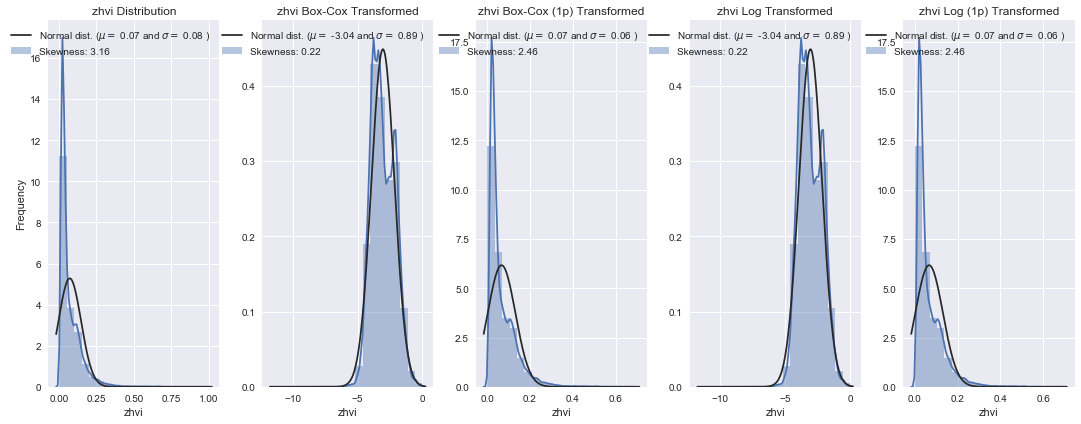

In [68]:
#entire new york state
distribution_illustration(0, allhomes_allzips4['zhvi'].dropna(), 'zhvi')

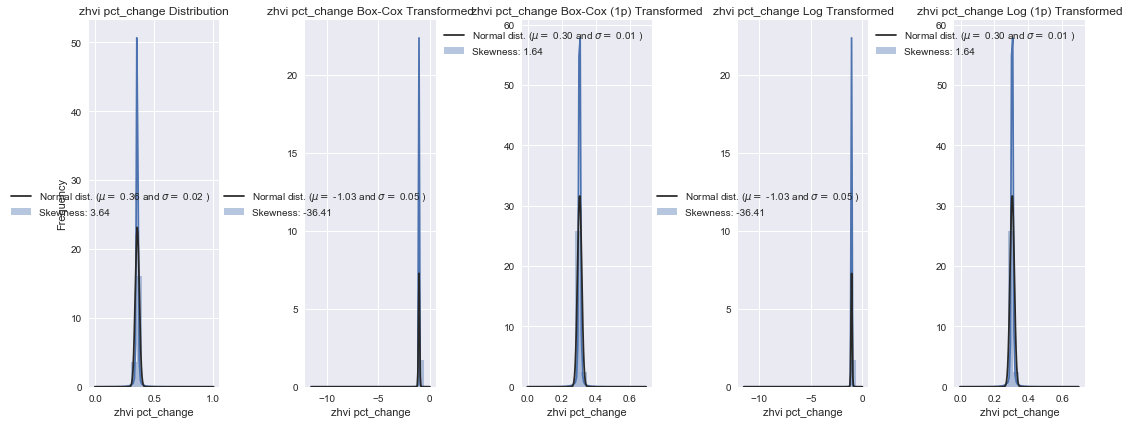

In [69]:
#entire new york state
distribution_illustration(0, allhomes_allzips4['zhvi pct_change'].dropna(), 'zhvi pct_change')

14905


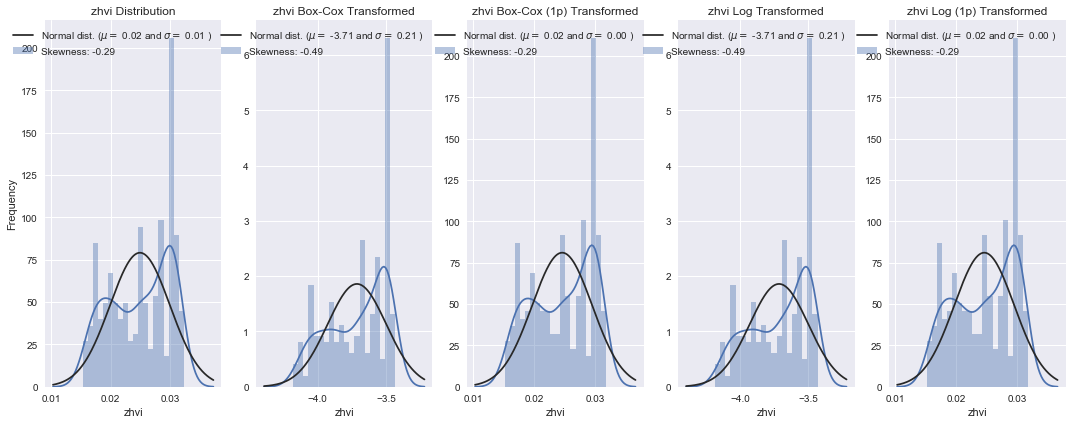

12077


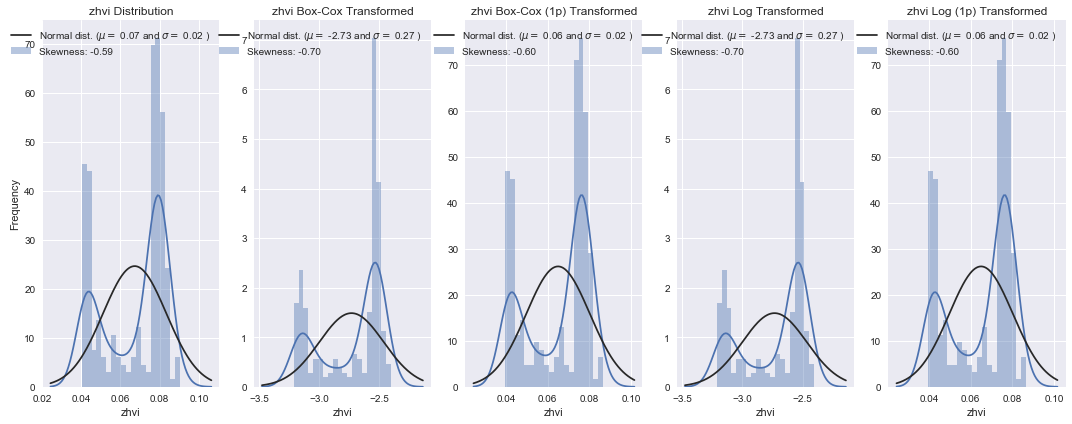

12118


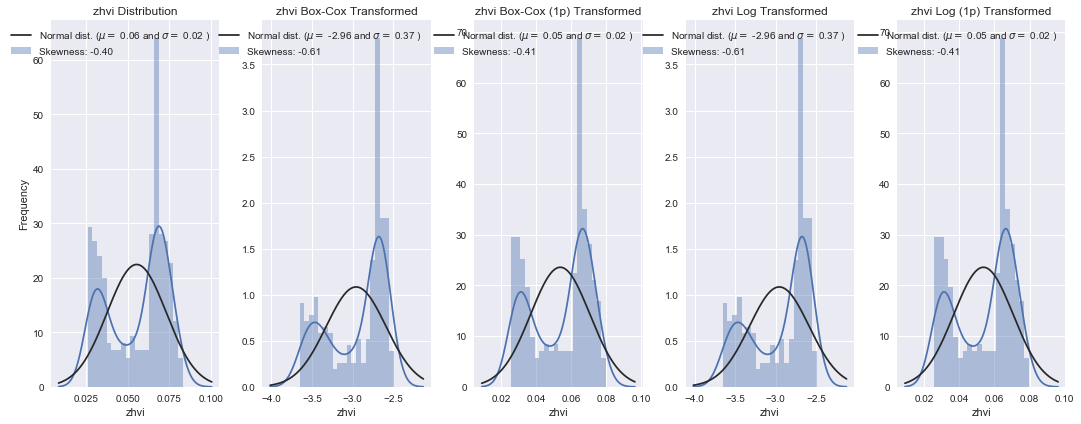

12116


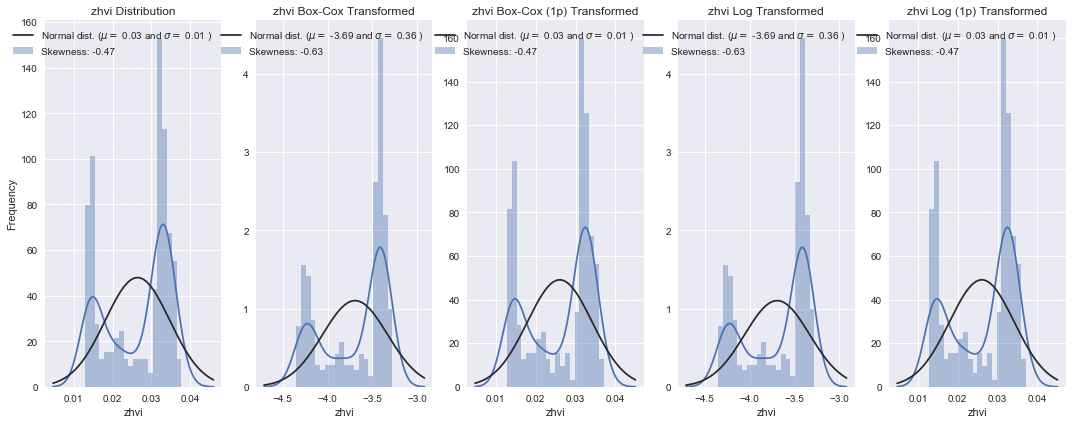

12110


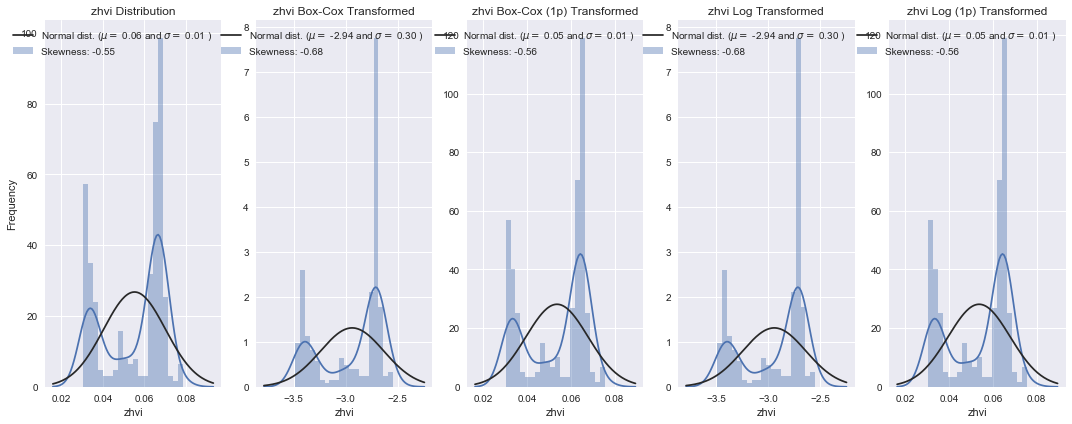

In [71]:
#a few zips
#Target: 'zhvi', trying to correct for skewness
for zipcode in example_zips:
    print(zipcode)
    distribution_illustration(0, allhomes_allzips4[allhomes_allzips4.zip == zipcode]['zhvi'].dropna(), 'zhvi')

14905


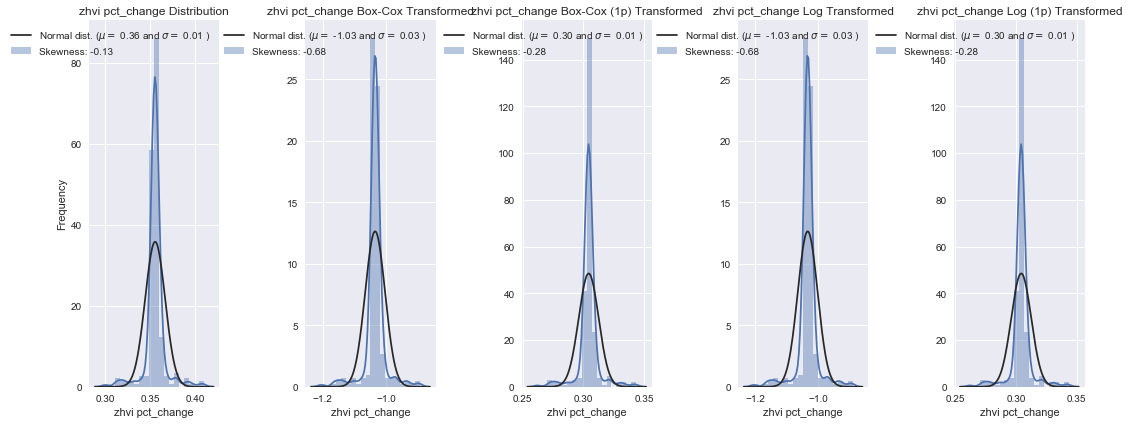

12077


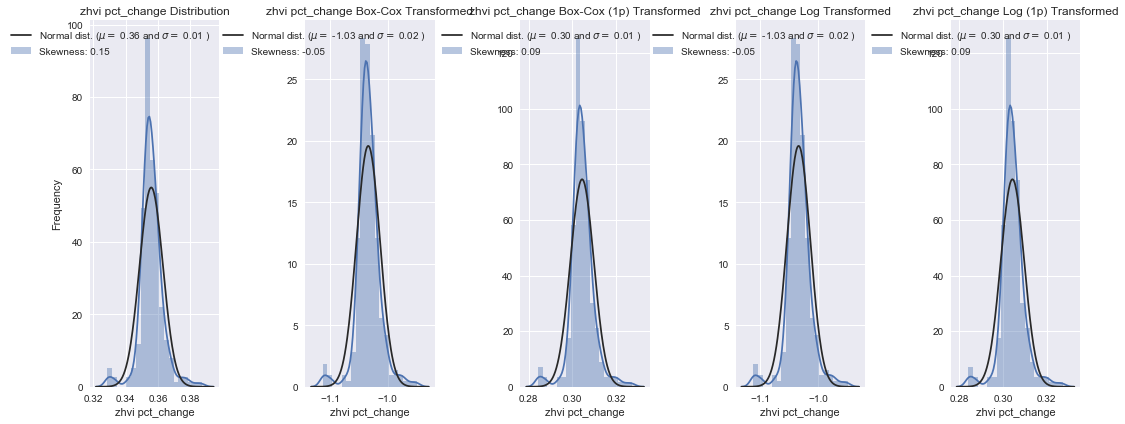

12118


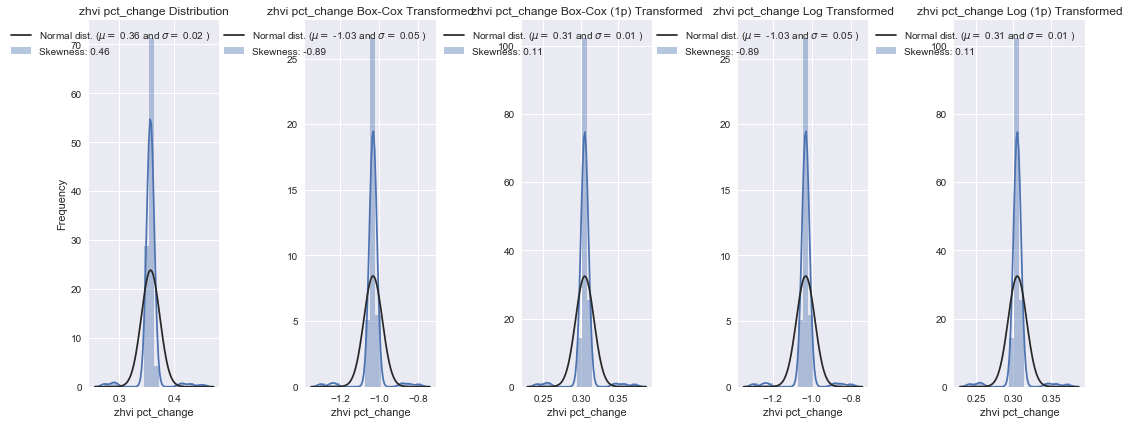

12116


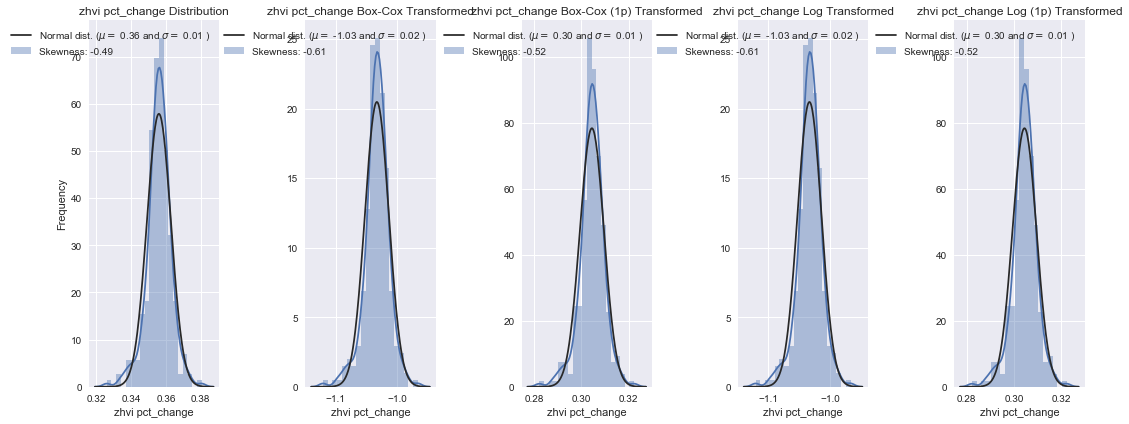

12110


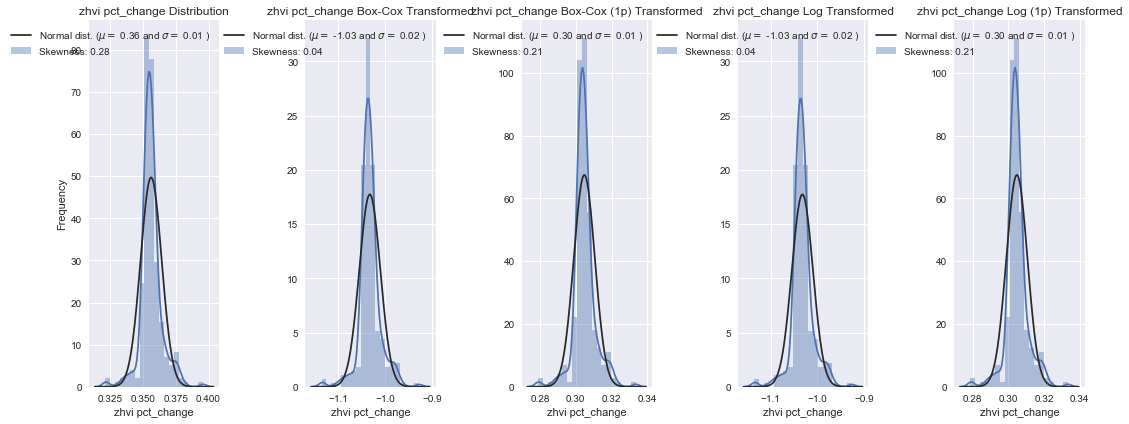

In [72]:
#a few zips
#Target: 'zhvi', trying to correct for skewness
for zipcode in example_zips:
    print(zipcode)
    distribution_illustration(0, allhomes_allzips4[allhomes_allzips4.zip == zipcode]['zhvi pct_change'].dropna(), 
                              'zhvi pct_change')

### Mortgage Rates and Change in Mortgage Rates

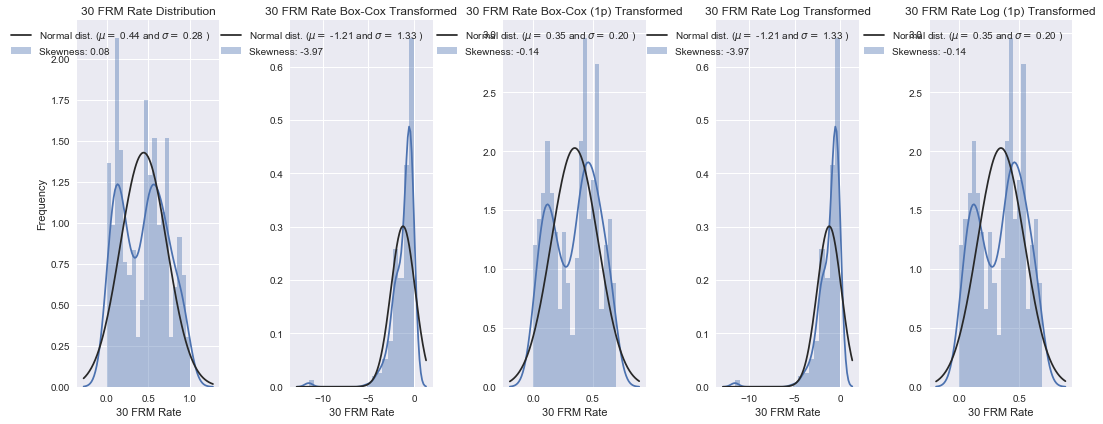

In [74]:
#Feature: '30 FRM Rate', trying to correct for skewness
zipcode = example_zips[0]
distribution_illustration(0, allhomes_allzips4[allhomes_allzips4.zip == zipcode]['30 FRM Rate'].dropna(), 
                          '30 FRM Rate')

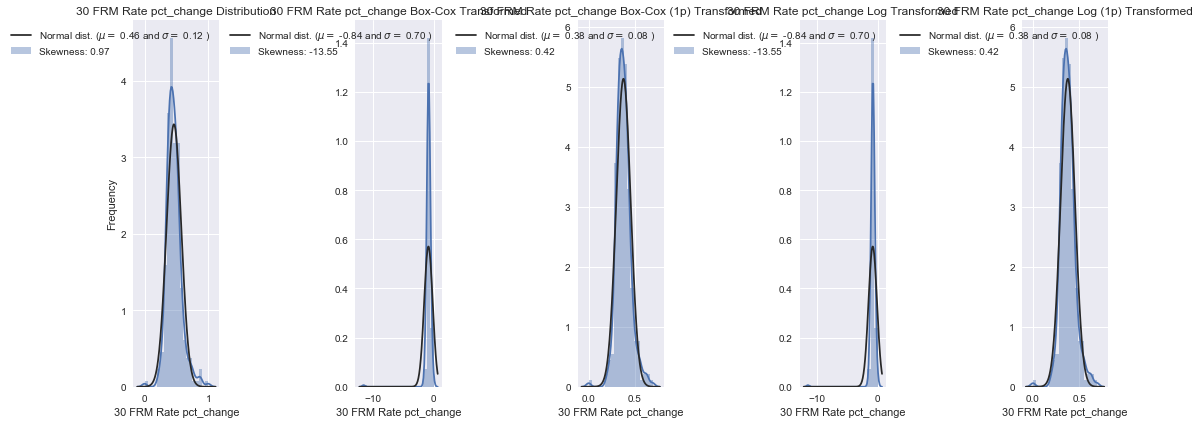

In [75]:
#Feature: '30 FRM Rate pct_change', trying to correct for skewness
zipcode = example_zips[0]
distribution_illustration(0, allhomes_allzips4[allhomes_allzips4.zip == zipcode]['30 FRM Rate pct_change'].dropna(), 
                          '30 FRM Rate pct_change')

### Fed Rates and Change in Fed Rates

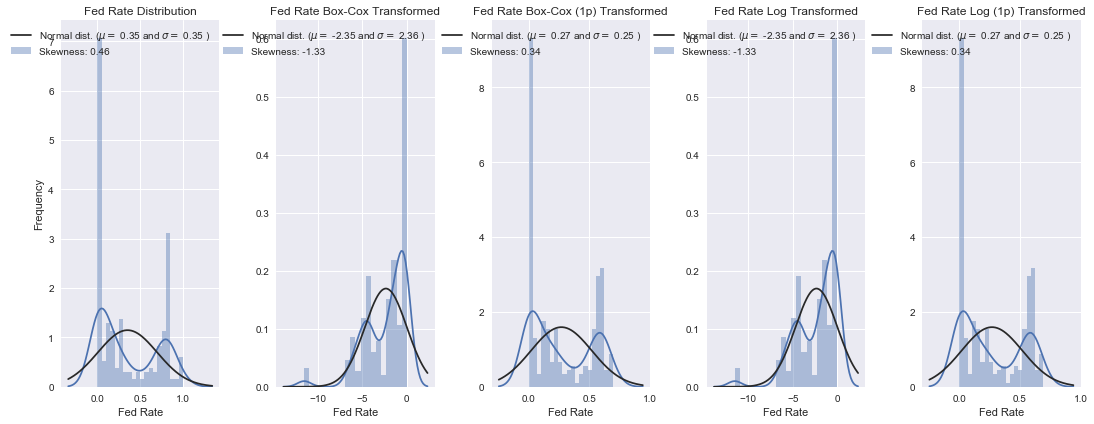

In [77]:
#Feature: 'Fed Rate', trying to correct for skewness
zipcode = example_zips[0]
distribution_illustration(0, allhomes_allzips4[allhomes_allzips4.zip == zipcode]['Fed Rate'].dropna(), 
                          'Fed Rate')

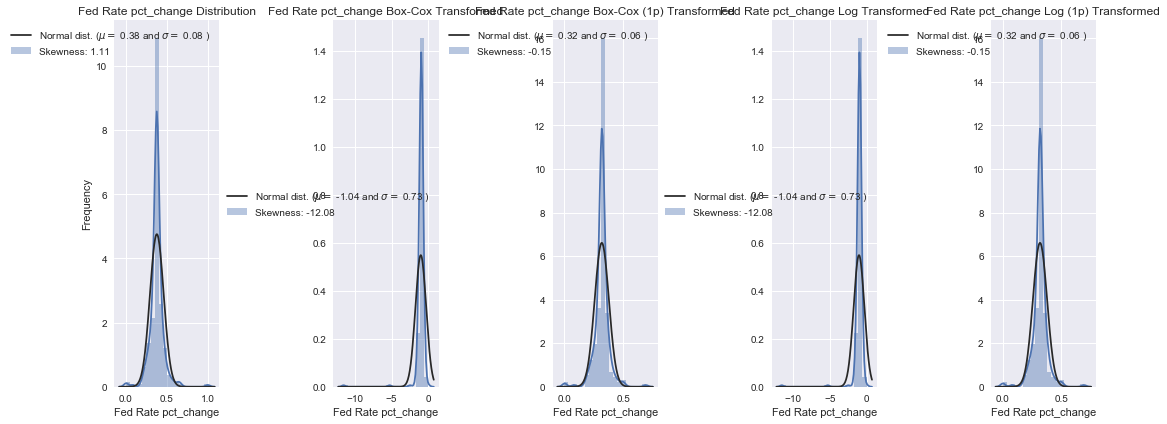

In [78]:
#Feature: 'Fed Rate pct_change', trying to correct for skewness
zipcode = example_zips[0]
distribution_illustration(0, allhomes_allzips4[allhomes_allzips4.zip == zipcode]['Fed Rate pct_change'].dropna(), 
                          'Fed Rate pct_change')

### Market Movements and Change in Market Movements

D_MA


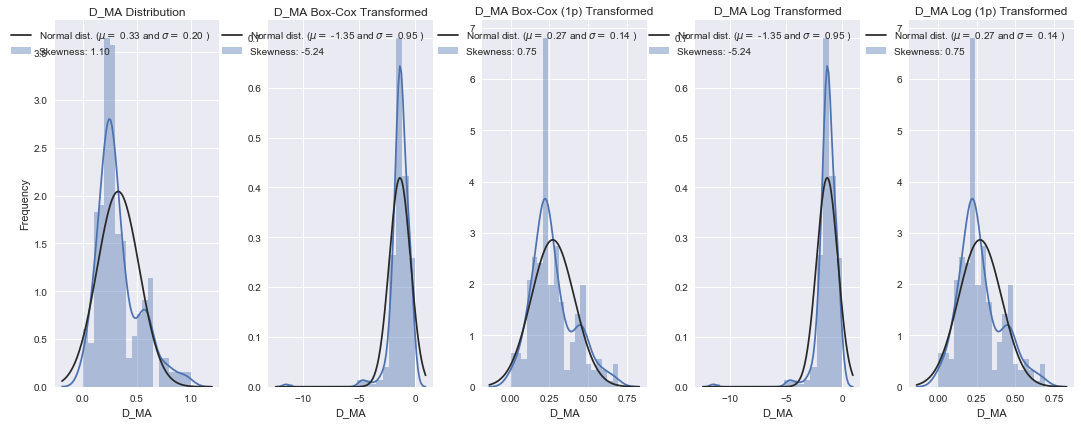

N_MA


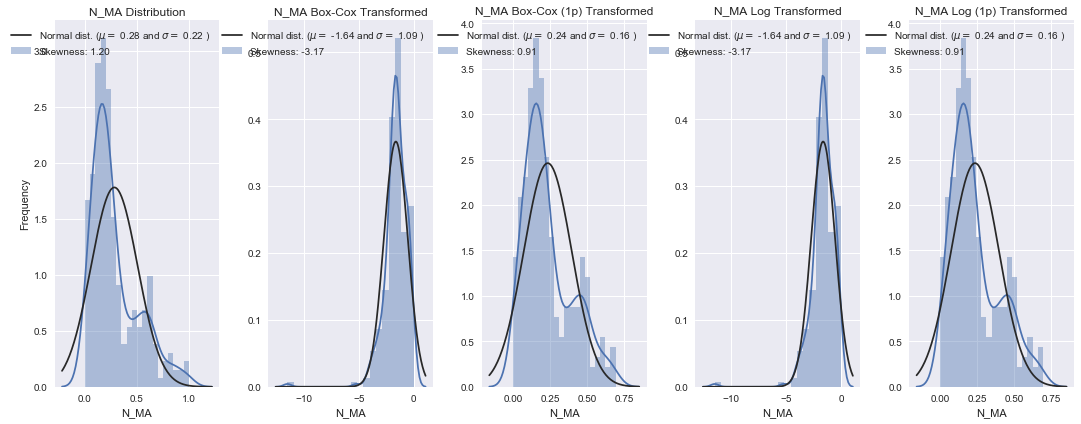

S_MA


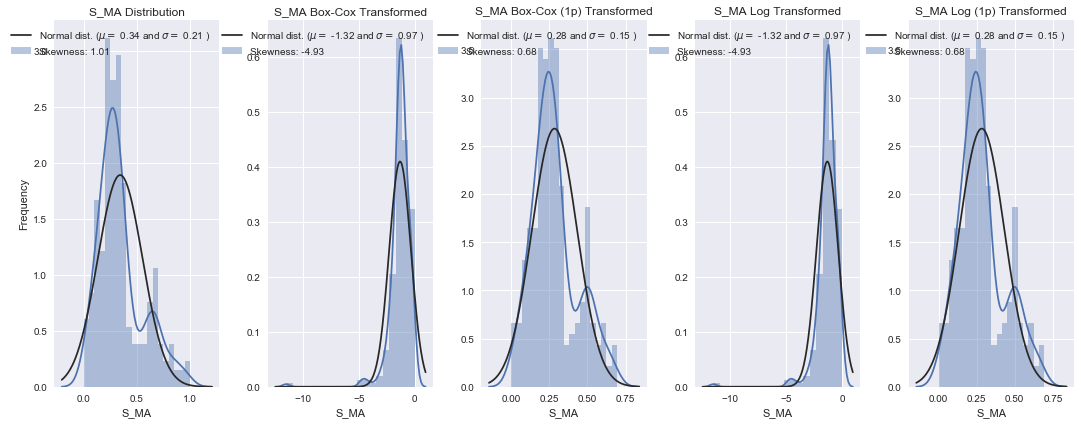

In [79]:
#Feature: 'Fed Rate pct_change', trying to correct for skewness
zipcode = example_zips[0]
for col in ['D_MA', 'N_MA', 'S_MA']:
    print(col)
    distribution_illustration(0, allhomes_allzips4[allhomes_allzips4.zip == zipcode][col].dropna(), col)

D_MA pct_change


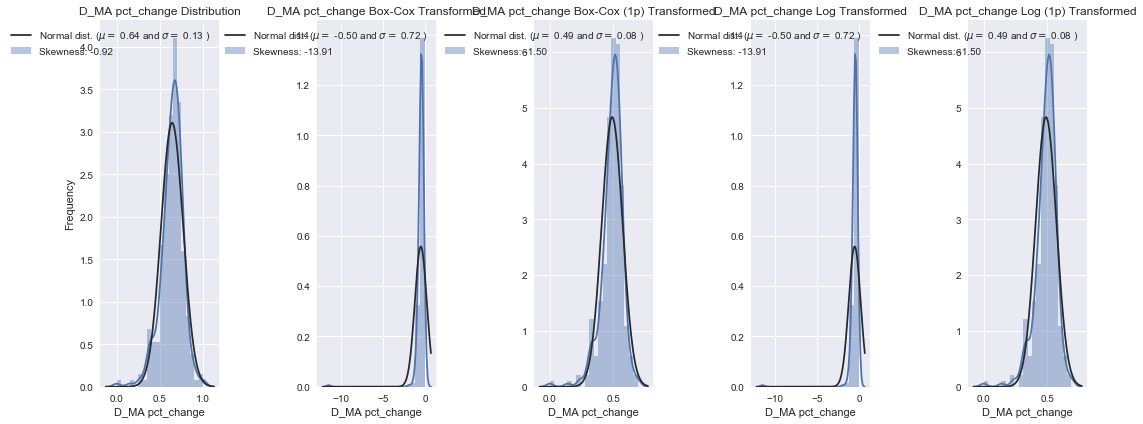

N_MA pct_change


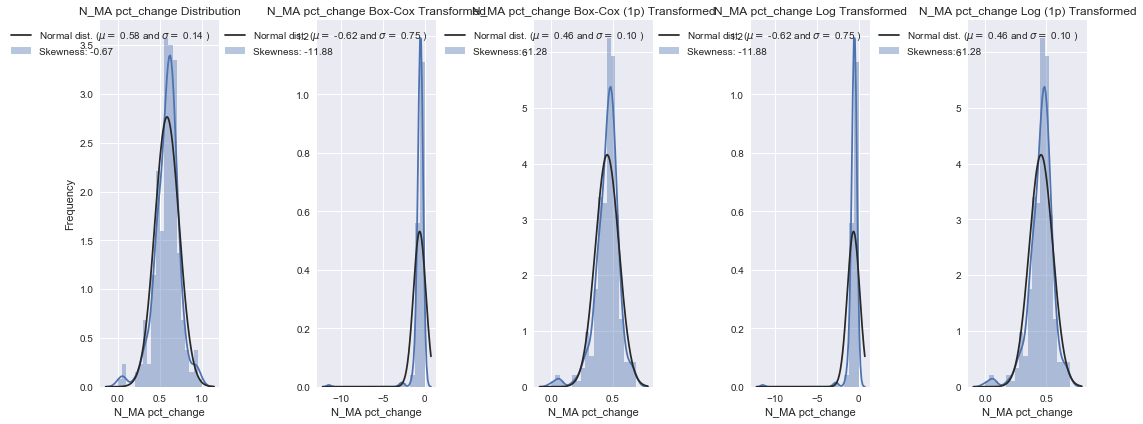

S_MA pct_change


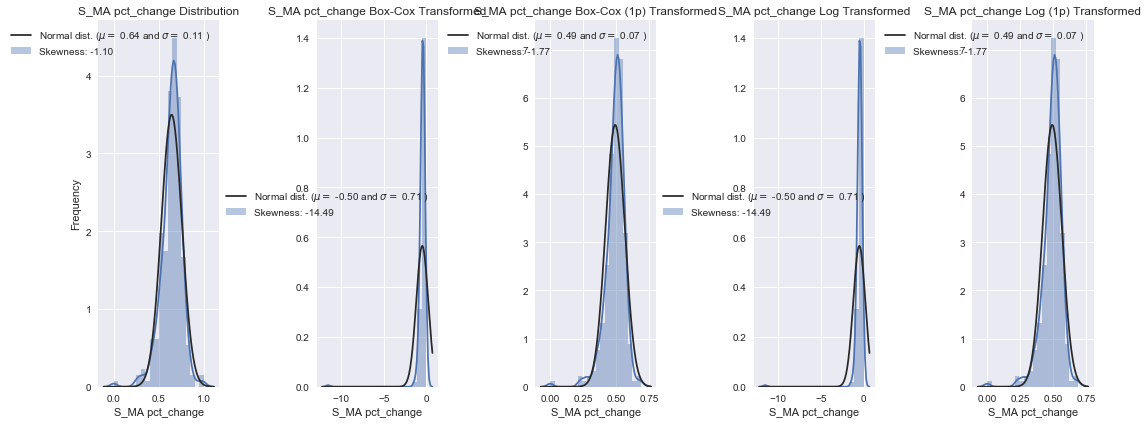

In [80]:
#Feature: '30 FRM Rate pct_change', trying to correct for skewness
for col in ['D_MA pct_change', 'N_MA pct_change', 'S_MA pct_change']:
    print(col)
    zipcode = example_zips[0]
    distribution_illustration(0, allhomes_allzips4[allhomes_allzips4.zip == zipcode][col].dropna(), col)

### Take a look if the features have any linear relationship with the target

### Mortgage Rates and Change in Mortgage Rates

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


30 FRM Rate v. zhvi:  (-0.8173175482009802, 1.9371118183018113e-64)
30 FRM Rate 1 v. zhvi:  (-0.8180833400143398, 1.1818191552971162e-64)
30 FRM Rate 6 v. zhvi:  (-0.8158119464711755, 5.08342665635483e-64)
30 FRM Rate 12 v. zhvi:  (-0.8211730942707066, 1.5714428442009633e-65)
30 FRM Rate 24 v. zhvi:  (-0.8403016049535147, 2.327132489257175e-71)


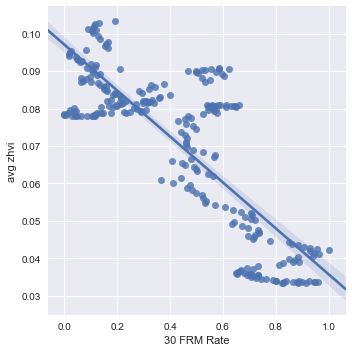

In [112]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24','zhvi']]
temp['id'] = temp.index

temp['avg zhvi'] = temp.groupby(['id'])['zhvi'].mean()
temp = temp[['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24', 'avg zhvi']].drop_duplicates()


sns.lmplot(data = temp, x = '30 FRM Rate', y = 'avg zhvi')
plt.tight_layout()
for col in ['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24']:
    print('{} v. zhvi: '.format(col), pearsonr(temp['avg zhvi'], temp[col]))

14905
30 FRM Rate v. zhvi:  (-0.9251915634624747, 7.963347681133759e-112)
30 FRM Rate 1 v. zhvi:  (-0.9253084842580431, 6.543857454733275e-112)
30 FRM Rate 6 v. zhvi:  (-0.9162759212105909, 1.055872292508032e-105)
30 FRM Rate 12 v. zhvi:  (-0.9108456569230468, 2.672756891936034e-102)
30 FRM Rate 24 v. zhvi:  (-0.9182619511592598, 5.2575096451351544e-107)
12077
30 FRM Rate v. zhvi:  (-0.7733854574445712, 1.3726828407095855e-53)
30 FRM Rate 1 v. zhvi:  (-0.7751226515792338, 5.701119788651269e-54)
30 FRM Rate 6 v. zhvi:  (-0.7767312427918498, 2.5092215659435042e-54)
30 FRM Rate 12 v. zhvi:  (-0.7816054964669119, 2.0004125240025097e-55)
30 FRM Rate 24 v. zhvi:  (-0.7908691991202321, 1.359877017004934e-57)
12118
30 FRM Rate v. zhvi:  (-0.8674141493763616, 4.337322130616545e-81)
30 FRM Rate 1 v. zhvi:  (-0.8690784303603836, 9.353316448129501e-82)
30 FRM Rate 6 v. zhvi:  (-0.8681318248344027, 2.2440409412313156e-81)
30 FRM Rate 12 v. zhvi:  (-0.868757546739379, 1.259310490312299e-81)
30 FRM R

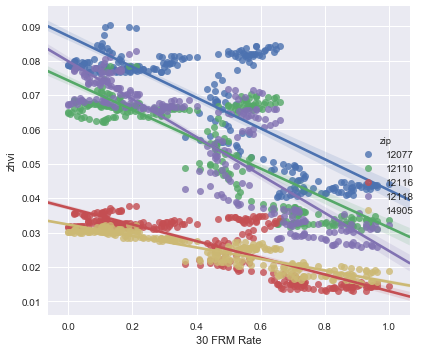

In [84]:
# for certain zipcodes
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], x = '30 FRM Rate', y = 'zhvi', hue = 'zip')
plt.tight_layout()
for zipcode in example_zips:
    print(zipcode)
    for col in ['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24']:
        print('{} v. zhvi: '.format(col), pearsonr(allhomes_allzips4[allhomes_allzips4.zip == zipcode]['zhvi'], 
                                                   allhomes_allzips4[allhomes_allzips4.zip == zipcode][col]))

all zips


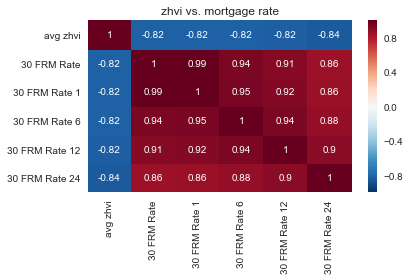

zip: 14905


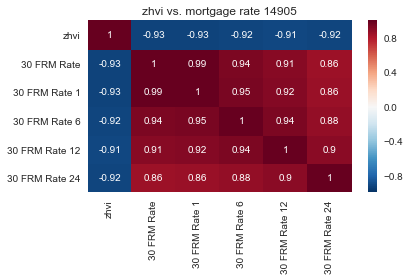

zip: 12077


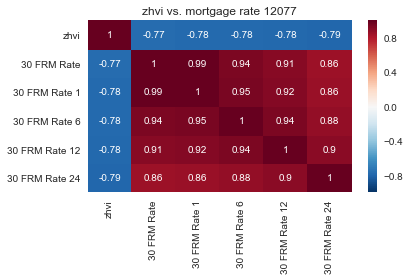

zip: 12118


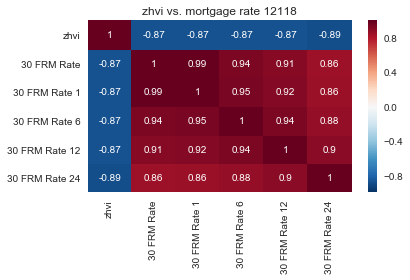

zip: 12116


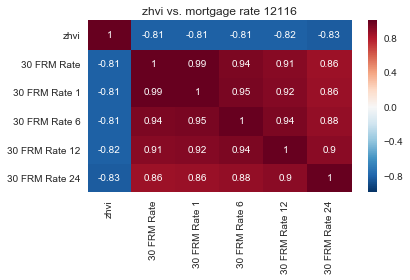

zip: 12110


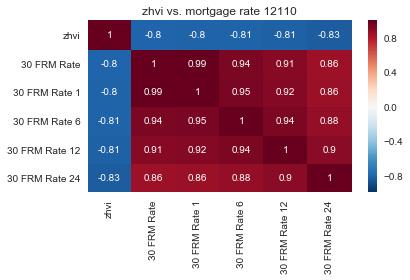

In [114]:
print('all zips')
heatmap1 = temp[['avg zhvi', '30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('zhvi vs. mortgage rate')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi', '30 FRM Rate', '30 FRM Rate 1',
                                                                    '30 FRM Rate 6', '30 FRM Rate 12',
                                                                    '30 FRM Rate 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. mortgage rate ' + zipcode)
    plt.tight_layout()
    plt.show()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


30 FRM Rate pct_change v. zhvi:  (0.058624522428287223, 0.3436305484665828)
30 FRM Rate pct_change 1 v. zhvi:  (0.05891766802742128, 0.34121879910448305)
30 FRM Rate pct_change 6 v. zhvi:  (0.062106509429333066, 0.31568251325397634)
30 FRM Rate pct_change 12 v. zhvi:  (0.02571354748431184, 0.6780789442937663)
30 FRM Rate pct_change 24 v. zhvi:  (-0.031237299779928143, 0.6140548192481228)


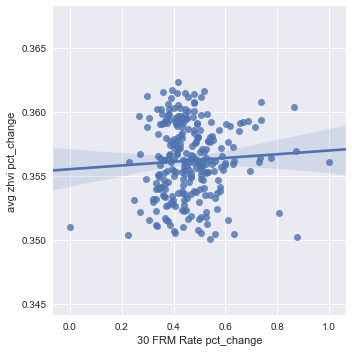

In [115]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['30 FRM Rate pct_change', '30 FRM Rate pct_change 1', '30 FRM Rate pct_change 6',
                          '30 FRM Rate pct_change 12', '30 FRM Rate pct_change 24', 'zhvi pct_change']]
temp['id'] = temp.index

temp['avg zhvi pct_change'] = temp.groupby(['id'])['zhvi pct_change'].mean()
temp = temp[['30 FRM Rate pct_change', '30 FRM Rate pct_change 1', '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12', 
             '30 FRM Rate pct_change 24', 'avg zhvi pct_change']].drop_duplicates()


sns.lmplot(data = temp, x = '30 FRM Rate pct_change', y = 'avg zhvi pct_change')
plt.tight_layout()
for col in ['30 FRM Rate pct_change', '30 FRM Rate pct_change 1', '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12', '30 FRM Rate pct_change 24']:
    print('{} v. zhvi: '.format(col), pearsonr(temp['avg zhvi pct_change'], temp[col]))

14905
30 FRM Rate v. zhvi % change:  (0.0789504415314384, 0.2018652778070265)
30 FRM Rate 1 v. zhvi % change:  (0.07994683758729017, 0.1962138881046621)
30 FRM Rate 6 v. zhvi % change:  (0.07251141848198615, 0.2412454220643553)
30 FRM Rate 12 v. zhvi % change:  (0.06052245900666726, 0.3282075178055023)
30 FRM Rate 24 v. zhvi % change:  (0.0741885534222969, 0.230505259226381)
12077
30 FRM Rate v. zhvi % change:  (0.037398534625093606, 0.5459602245854243)
30 FRM Rate 1 v. zhvi % change:  (0.0411987533304375, 0.5059024278539068)
30 FRM Rate 6 v. zhvi % change:  (0.050497784167662374, 0.4147540726951483)
30 FRM Rate 12 v. zhvi % change:  (0.03851154237003396, 0.5340680765763737)
30 FRM Rate 24 v. zhvi % change:  (0.04927529833449915, 0.42615514578685554)
12118
30 FRM Rate v. zhvi % change:  (0.057632400989288075, 0.35187292776354107)
30 FRM Rate 1 v. zhvi % change:  (0.05007003910610347, 0.41872274118954766)
30 FRM Rate 6 v. zhvi % change:  (0.05299629491538324, 0.39201805417724245)
30 FRM

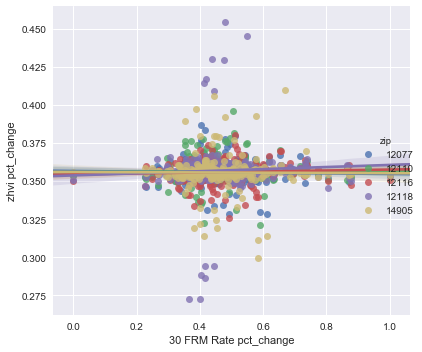

In [116]:
# for certain zipcodes
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], x = '30 FRM Rate pct_change', 
           y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()
for zipcode in example_zips:
    print(zipcode)
    for col in ['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24']:
        print('{} v. zhvi % change: '.format(col), pearsonr(allhomes_allzips4[allhomes_allzips4.zip == zipcode]['zhvi pct_change'], 
                                                   allhomes_allzips4[allhomes_allzips4.zip == zipcode][col]))

all zips


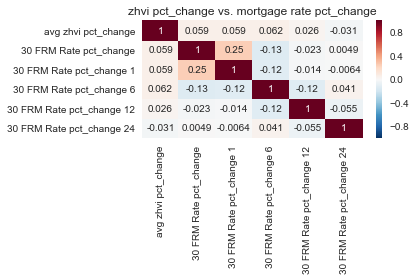

zip: 14905


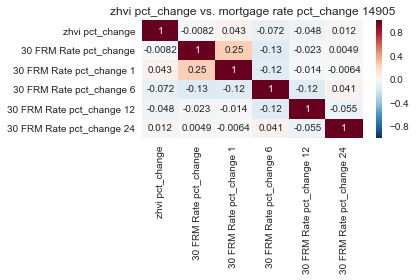

zip: 12077


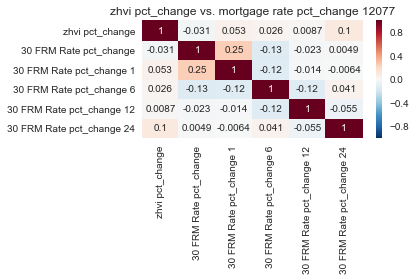

zip: 12118


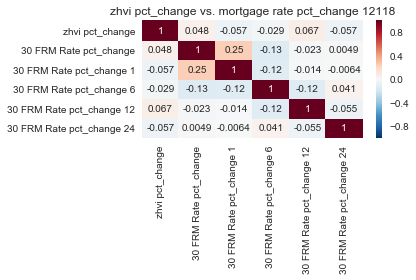

zip: 12116


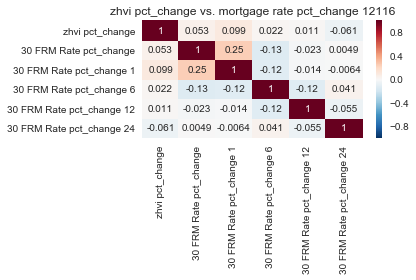

zip: 12110


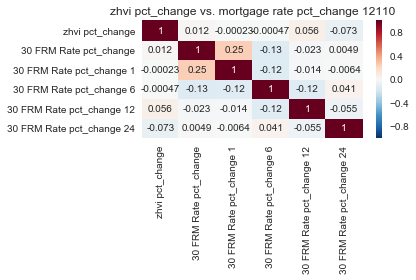

In [117]:
print('all zips')
heatmap1 = temp[['avg zhvi pct_change', '30 FRM Rate pct_change', '30 FRM Rate pct_change 1', '30 FRM Rate pct_change 6', 
                 '30 FRM Rate pct_change 12', '30 FRM Rate pct_change 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('zhvi pct_change vs. mortgage rate pct_change')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi pct_change', '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
                                                                    '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
                                                                    '30 FRM Rate pct_change 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi pct_change vs. mortgage rate pct_change ' + zipcode)
    plt.tight_layout()
    plt.show()

### Fed Rates and Change in Fed Rates

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Fed Rate v. zhvi:  (-0.6860022909688837, 6.440734477229965e-38)
Fed Rate 1 v. zhvi:  (-0.6876611973477301, 3.659484678202869e-38)
Fed Rate 6 v. zhvi:  (-0.6979891320008208, 9.933098773109838e-40)
Fed Rate 12 v. zhvi:  (-0.7155556077016338, 1.4910235562436268e-42)
Fed Rate 24 v. zhvi:  (-0.7355342955529641, 4.902811769196548e-46)


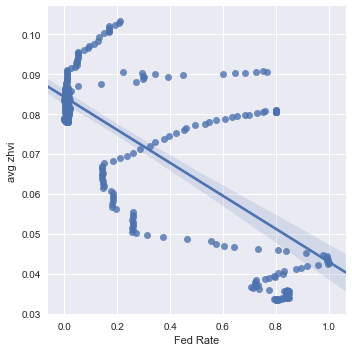

In [118]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 'Fed Rate 12', 'Fed Rate 24', 'zhvi']]
temp['id'] = temp.index

temp['avg zhvi'] = temp.groupby(['id'])['zhvi'].mean()
temp = temp[['Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 'Fed Rate 12', 'Fed Rate 24', 'avg zhvi']].drop_duplicates()


sns.lmplot(data = temp, x = 'Fed Rate', y = 'avg zhvi')
plt.tight_layout()
for col in ['Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 'Fed Rate 12', 'Fed Rate 24']:
    print('{} v. zhvi: '.format(col), pearsonr(temp['avg zhvi'], temp[col]))

14905
Fed Rate v. zhvi:  (-0.7786656496992529, 9.26758556352507e-55)
Fed Rate 1 v. zhvi:  (-0.7817822662571247, 1.822861131647376e-55)
Fed Rate 6 v. zhvi:  (-0.7971075110781719, 4.0819545143510235e-59)
Fed Rate 12 v. zhvi:  (-0.8177059688445835, 1.5081023602408249e-64)
Fed Rate 24 v. zhvi:  (-0.815671997600751, 5.557870809996277e-64)
12077
Fed Rate v. zhvi:  (-0.6315350002337131, 1.1191562775255933e-30)
Fed Rate 1 v. zhvi:  (-0.6352946626703462, 3.9404751782058067e-31)
Fed Rate 6 v. zhvi:  (-0.6556811911092627, 1.057272565323538e-33)
Fed Rate 12 v. zhvi:  (-0.6860269662012212, 6.386979418637075e-38)
Fed Rate 24 v. zhvi:  (-0.7282306627777764, 9.992322621009692e-45)
12118
Fed Rate v. zhvi:  (-0.7126557002688956, 4.5104431513008145e-42)
Fed Rate 1 v. zhvi:  (-0.7155984253622668, 1.4667002584967097e-42)
Fed Rate 6 v. zhvi:  (-0.7285385173512895, 8.81745418784258e-45)
Fed Rate 12 v. zhvi:  (-0.748848596258275, 1.542718446982204e-48)
Fed Rate 24 v. zhvi:  (-0.7767280446023902, 2.51333624671

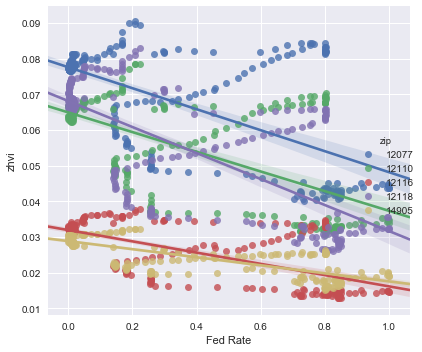

In [119]:
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], x = 'Fed Rate', y = 'zhvi', hue = 'zip')
plt.tight_layout()
for zipcode in example_zips:
    print(zipcode)
    for col in ['Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 'Fed Rate 12', 'Fed Rate 24']:
        print('{} v. zhvi: '.format(col), pearsonr(allhomes_allzips4[allhomes_allzips4.zip == zipcode]['zhvi'], 
                                                   allhomes_allzips4[allhomes_allzips4.zip == zipcode][col]))

all zips


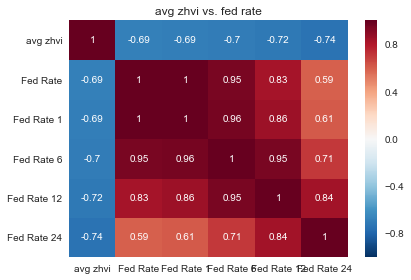

zip: 14905


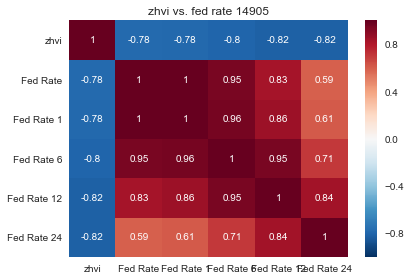

zip: 12077


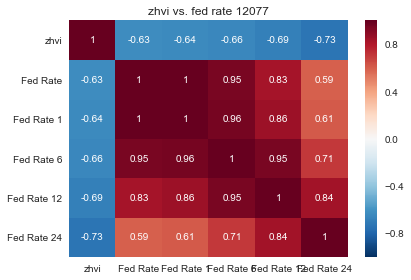

zip: 12118


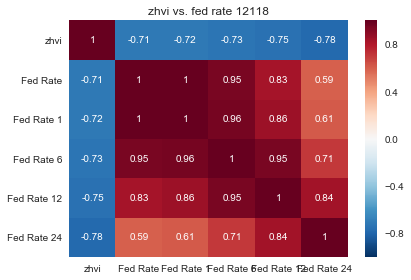

zip: 12116


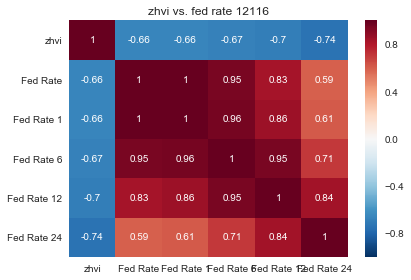

zip: 12110


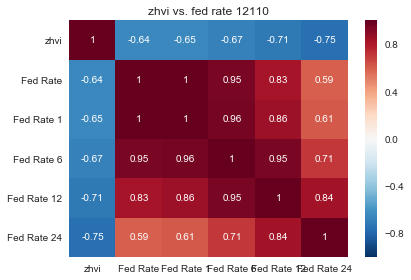

In [121]:
print('all zips')
heatmap1 = temp[['avg zhvi', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 'Fed Rate 12', 'Fed Rate 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('avg zhvi vs. fed rate')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6',
                                                                    'Fed Rate 12', 'Fed Rate 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. fed rate ' + zipcode)
    plt.tight_layout()
    plt.show()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Fed Rate pct_change v. zhvi % change:  (0.13021950978596317, 0.03479449378562821)
Fed Rate pct_change 1 v. zhvi % change:  (0.13048897030705273, 0.03441738565937001)
Fed Rate pct_change 6 v. zhvi % change:  (0.12798245059073865, 0.03806283771350226)
Fed Rate pct_change 12 v. zhvi % change:  (0.07061717444738598, 0.25379154455347885)
Fed Rate pct_change 24 v. zhvi % change:  (0.021434084157039474, 0.7293528913074125)


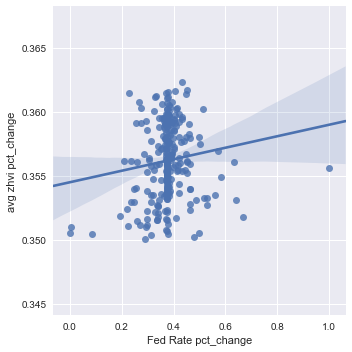

In [130]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['Fed Rate pct_change', 'Fed Rate pct_change 1', 'Fed Rate pct_change 6', 
                          'Fed Rate pct_change 12', 'Fed Rate pct_change 24', 'zhvi pct_change']]
temp['id'] = temp.index

temp['avg zhvi pct_change'] = temp.groupby(['id'])['zhvi pct_change'].mean()
temp = temp[['Fed Rate pct_change', 'Fed Rate pct_change 1', 'Fed Rate pct_change 6',
             'Fed Rate pct_change 12', 'Fed Rate pct_change 24', 'avg zhvi pct_change']].drop_duplicates()


sns.lmplot(data = temp, x = 'Fed Rate pct_change', y = 'avg zhvi pct_change')
plt.tight_layout()
for col in ['Fed Rate pct_change', 'Fed Rate pct_change 1', 'Fed Rate pct_change 6',
            'Fed Rate pct_change 12', 'Fed Rate pct_change 24']:
    print('{} v. zhvi % change: '.format(col), pearsonr(temp['avg zhvi pct_change'], temp[col]))

14905
Fed Rate pct_change v. zhvi % change:  (0.023051150772359634, 2.9435450524297587e-27)
Fed Rate pct_change 1 v. zhvi % change:  (0.023318634127642818, 7.429970963119601e-28)
Fed Rate pct_change 6 v. zhvi % change:  (0.02311119988984911, 2.163909812502963e-27)
Fed Rate pct_change 12 v. zhvi % change:  (0.013892724137140771, 7.164876071904174e-11)
Fed Rate pct_change 24 v. zhvi % change:  (0.006426379769180375, 0.002573684198028296)
12077
Fed Rate pct_change v. zhvi % change:  (0.023051150772359634, 2.9435450524297587e-27)
Fed Rate pct_change 1 v. zhvi % change:  (0.023318634127642818, 7.429970963119601e-28)
Fed Rate pct_change 6 v. zhvi % change:  (0.02311119988984911, 2.163909812502963e-27)
Fed Rate pct_change 12 v. zhvi % change:  (0.013892724137140771, 7.164876071904174e-11)
Fed Rate pct_change 24 v. zhvi % change:  (0.006426379769180375, 0.002573684198028296)
12118
Fed Rate pct_change v. zhvi % change:  (0.023051150772359634, 2.9435450524297587e-27)
Fed Rate pct_change 1 v. zhv

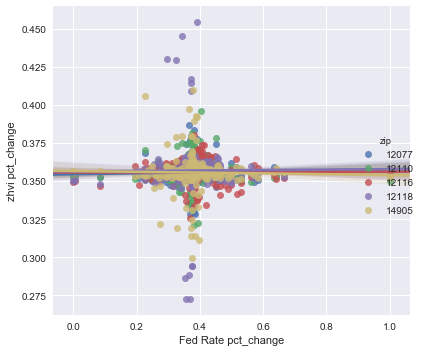

In [128]:
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], 
           x = 'Fed Rate pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['Fed Rate pct_change', 'Fed Rate pct_change 1', 'Fed Rate pct_change 6', 
                'Fed Rate pct_change 12', 'Fed Rate pct_change 24']:
        temp = allhomes_allzips4[allhomes_allzips4.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi % change: '.format(col), pearsonr(allhomes_allzips4['zhvi pct_change'], allhomes_allzips4[col]))

all zips


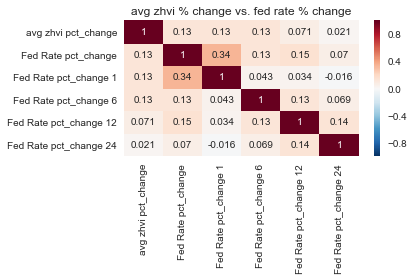

zip: 14905


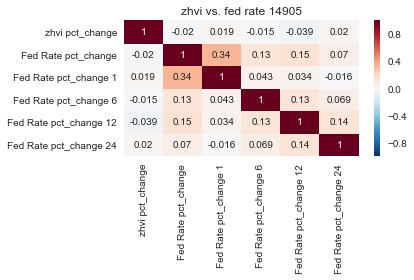

zip: 12077


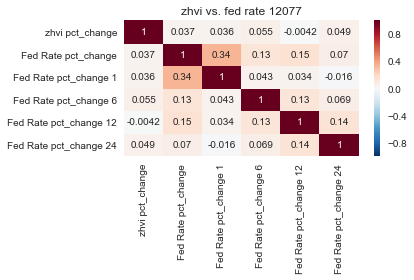

zip: 12118


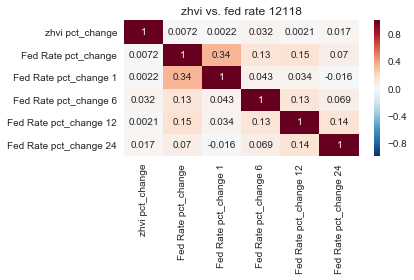

zip: 12116


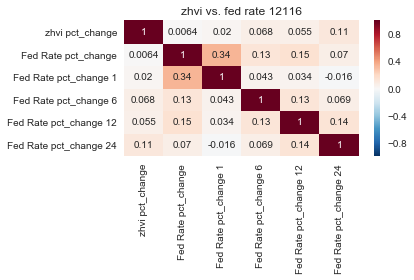

zip: 12110


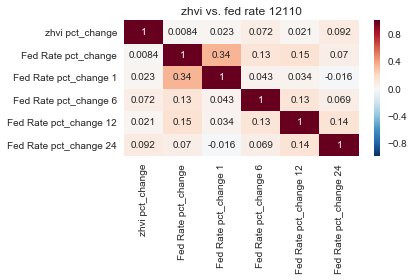

In [132]:
print('all zips')
heatmap1 = temp[['avg zhvi pct_change', 'Fed Rate pct_change', 'Fed Rate pct_change 1',
                 'Fed Rate pct_change 6', 'Fed Rate pct_change 12', 'Fed Rate pct_change 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('avg zhvi % change vs. fed rate % change')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi pct_change', 'Fed Rate pct_change', 'Fed Rate pct_change 1',
                                                  'Fed Rate pct_change 6', 'Fed Rate pct_change 12', 'Fed Rate pct_change 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. fed rate ' + zipcode)
    plt.tight_layout()
    plt.show()

### Market Performance and Change in Market Performance

### Dow Jones Industrial

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


D_MA v. zhvi:  (0.7184405880887047, 4.889055990870443e-43)
D_MA 1 v. zhvi:  (0.7236215330309332, 6.370458177120833e-44)
D_MA 6 v. zhvi:  (0.7551041932204826, 9.06892579537096e-50)
D_MA 12 v. zhvi:  (0.7813268935661266, 2.3155973222788095e-55)
D_MA 24 v. zhvi:  (0.8203135808942825, 2.7653228614457242e-65)


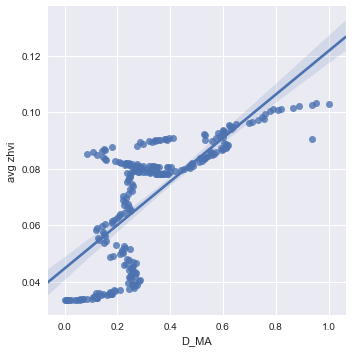

In [140]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['D_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 'zhvi']]
temp['id'] = temp.index

temp['avg zhvi'] = temp.groupby(['id'])['zhvi'].mean()
temp = temp[['D_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 'avg zhvi']].drop_duplicates()


sns.lmplot(data = temp, x = 'D_MA', y = 'avg zhvi')
plt.tight_layout()
for col in ['D_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24']:
    print('{} v. zhvi: '.format(col), pearsonr(temp['avg zhvi'], temp[col]))

14905
D_MA v. zhvi:  (0.19380676053871188, 0.0)
D_MA 1 v. zhvi:  (0.19527840253950277, 0.0)
D_MA 6 v. zhvi:  (0.20404590403986858, 0.0)
D_MA 12 v. zhvi:  (0.21136285690326134, 0.0)
D_MA 24 v. zhvi:  (0.22192464215281055, 0.0)
12077
D_MA v. zhvi:  (0.19380676053871188, 0.0)
D_MA 1 v. zhvi:  (0.19527840253950277, 0.0)
D_MA 6 v. zhvi:  (0.20404590403986858, 0.0)
D_MA 12 v. zhvi:  (0.21136285690326134, 0.0)
D_MA 24 v. zhvi:  (0.22192464215281055, 0.0)
12118
D_MA v. zhvi:  (0.19380676053871188, 0.0)
D_MA 1 v. zhvi:  (0.19527840253950277, 0.0)
D_MA 6 v. zhvi:  (0.20404590403986858, 0.0)
D_MA 12 v. zhvi:  (0.21136285690326134, 0.0)
D_MA 24 v. zhvi:  (0.22192464215281055, 0.0)
12116
D_MA v. zhvi:  (0.19380676053871188, 0.0)
D_MA 1 v. zhvi:  (0.19527840253950277, 0.0)
D_MA 6 v. zhvi:  (0.20404590403986858, 0.0)
D_MA 12 v. zhvi:  (0.21136285690326134, 0.0)
D_MA 24 v. zhvi:  (0.22192464215281055, 0.0)
12110
D_MA v. zhvi:  (0.19380676053871188, 0.0)
D_MA 1 v. zhvi:  (0.19527840253950277, 0.0)
D_MA

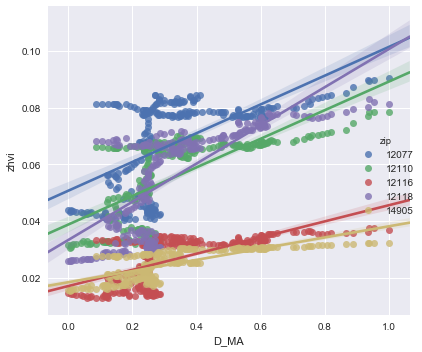

In [137]:
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], 
           x = 'D_MA', y = 'zhvi', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['D_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24']:
        temp = allhomes_allzips4[allhomes_allzips4.zip == zipcode][[col, 'zhvi']]
        print('{} v. zhvi: '.format(col), pearsonr(allhomes_allzips4['zhvi'], allhomes_allzips4[col]))

all zips


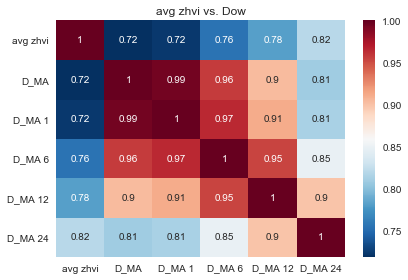

zip: 14905


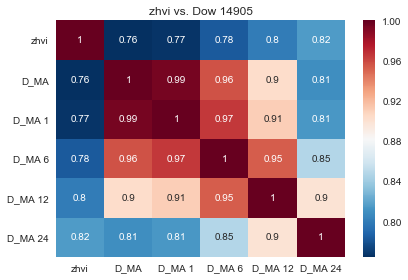

zip: 12077


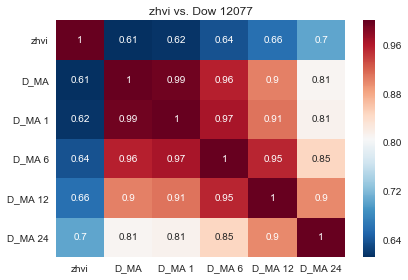

zip: 12118


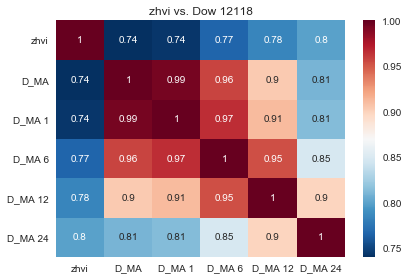

zip: 12116


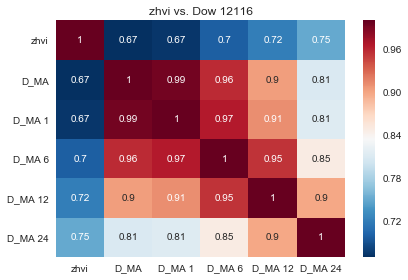

zip: 12110


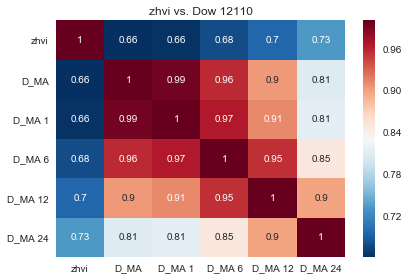

In [141]:
print('all zips')
heatmap1 = temp[['avg zhvi', 'D_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('avg zhvi vs. Dow')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi', 'D_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. Dow ' + zipcode)
    plt.tight_layout()
    plt.show()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


D_MA pct_change v. zhvi % change:  (0.030841593794545628, 0.6185526686001996)
D_MA pct_change 1 v. zhvi % change:  (0.0018487331541056755, 0.9761957509844394)
D_MA pct_change 6 v. zhvi % change:  (0.016306005766840638, 0.7923988357958729)
D_MA pct_change 12 v. zhvi % change:  (-0.009764021860727857, 0.8747756786603482)
D_MA pct_change 24 v. zhvi % change:  (0.0092780937192601, 0.8809603521242276)


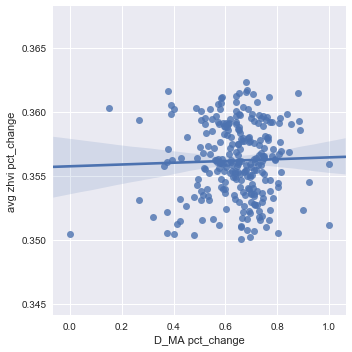

In [147]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12', 
                          'D_MA pct_change 24', 'zhvi pct_change']]
temp['id'] = temp.index

temp['avg zhvi pct_change'] = temp.groupby(['id'])['zhvi pct_change'].mean()
temp = temp[['D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12', 'D_MA pct_change 24', 'avg zhvi pct_change']].drop_duplicates()


sns.lmplot(data = temp, x = 'D_MA pct_change', y = 'avg zhvi pct_change')
plt.tight_layout()
for col in ['D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12', 'D_MA pct_change 24']:
    print('{} v. zhvi % change: '.format(col), pearsonr(temp['avg zhvi pct_change'], temp[col]))

14905
D_MA pct_change v. zhvi % change:  (0.0069922764037684965, 0.0010380603886527668)
D_MA pct_change 1 v. zhvi % change:  (0.002151735951928375, 0.31280901900504304)
D_MA pct_change 6 v. zhvi % change:  (0.005120942821088114, 0.01629829010531125)
D_MA pct_change 12 v. zhvi % change:  (-0.0006060231366709009, 0.7761991911548826)
D_MA pct_change 24 v. zhvi % change:  (0.0023480962667151275, 0.27069861024000025)
12077
D_MA pct_change v. zhvi % change:  (0.0069922764037684965, 0.0010380603886527668)
D_MA pct_change 1 v. zhvi % change:  (0.002151735951928375, 0.31280901900504304)
D_MA pct_change 6 v. zhvi % change:  (0.005120942821088114, 0.01629829010531125)
D_MA pct_change 12 v. zhvi % change:  (-0.0006060231366709009, 0.7761991911548826)
D_MA pct_change 24 v. zhvi % change:  (0.0023480962667151275, 0.27069861024000025)
12118
D_MA pct_change v. zhvi % change:  (0.0069922764037684965, 0.0010380603886527668)
D_MA pct_change 1 v. zhvi % change:  (0.002151735951928375, 0.31280901900504304)

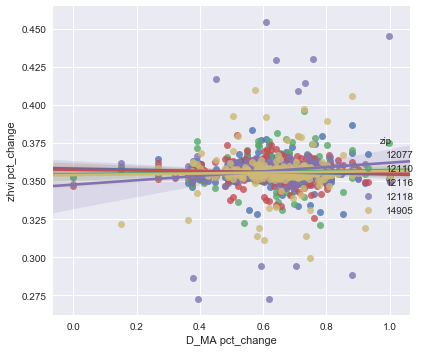

In [145]:
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], 
           x = 'D_MA pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12', 'D_MA pct_change 24']:
        temp = allhomes_allzips4[allhomes_allzips4.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi % change: '.format(col), pearsonr(allhomes_allzips4['zhvi pct_change'], allhomes_allzips4[col]))

all zips


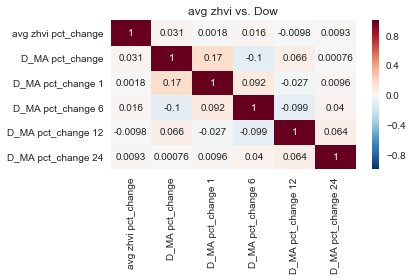

zip: 14905


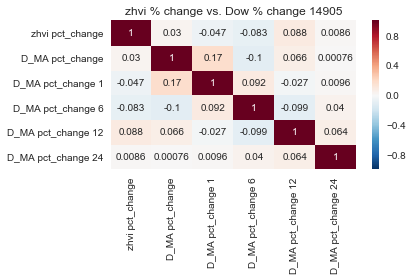

zip: 12077


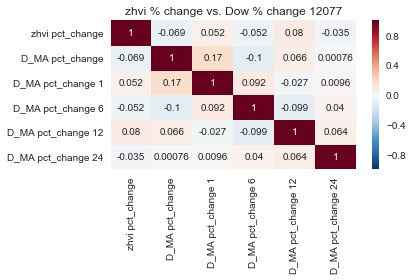

zip: 12118


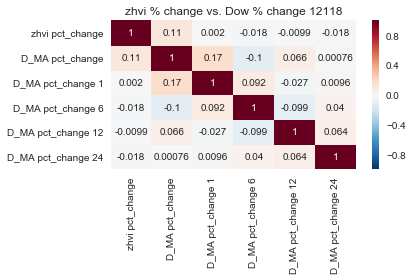

zip: 12116


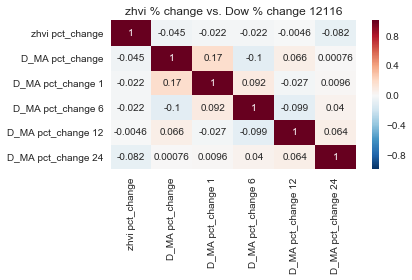

zip: 12110


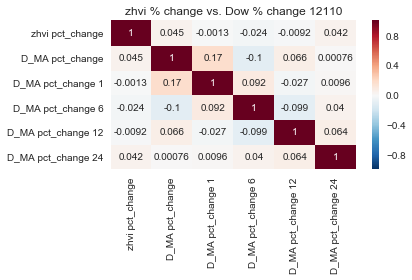

In [148]:
print('all zips')
heatmap1 = temp[['avg zhvi pct_change', 'D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12', 'D_MA pct_change 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('avg zhvi vs. Dow')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi pct_change', 'D_MA pct_change', 'D_MA pct_change 1', 
                                                                    'D_MA pct_change 6', 'D_MA pct_change 12', 'D_MA pct_change 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi % change vs. Dow % change ' + zipcode)
    plt.tight_layout()
    plt.show()

### S&P 500

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


S_MA v. zhvi:  (0.629889859241104, 1.759177439202323e-30)
S_MA 1 v. zhvi:  (0.6342587312382006, 5.261216806579167e-31)
S_MA 6 v. zhvi:  (0.6579589556398672, 5.30217175283541e-34)
S_MA 12 v. zhvi:  (0.6819262636557959, 2.542572706060087e-37)
S_MA 24 v. zhvi:  (0.7260956902678589, 2.3678746665990597e-44)


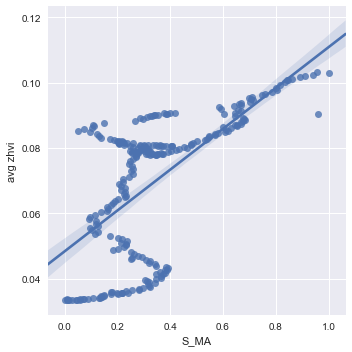

In [152]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24', 'zhvi']]
temp['id'] = temp.index

temp['avg zhvi'] = temp.groupby(['id'])['zhvi'].mean()
temp = temp[['S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24', 'avg zhvi']].drop_duplicates()


sns.lmplot(data = temp, x = 'S_MA', y = 'avg zhvi')
plt.tight_layout()
for col in ['S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24']:
    print('{} v. zhvi: '.format(col), pearsonr(temp['avg zhvi'], temp[col]))

14905
S_MA v. zhvi:  (0.17082249203961436, 0.0)
S_MA 1 v. zhvi:  (0.17204823261326008, 0.0)
S_MA 6 v. zhvi:  (0.17869005721284228, 0.0)
S_MA 12 v. zhvi:  (0.18532206123304462, 0.0)
S_MA 24 v. zhvi:  (0.19710180817176806, 0.0)
12077
S_MA v. zhvi:  (0.17082249203961436, 0.0)
S_MA 1 v. zhvi:  (0.17204823261326008, 0.0)
S_MA 6 v. zhvi:  (0.17869005721284228, 0.0)
S_MA 12 v. zhvi:  (0.18532206123304462, 0.0)
S_MA 24 v. zhvi:  (0.19710180817176806, 0.0)
12118
S_MA v. zhvi:  (0.17082249203961436, 0.0)
S_MA 1 v. zhvi:  (0.17204823261326008, 0.0)
S_MA 6 v. zhvi:  (0.17869005721284228, 0.0)
S_MA 12 v. zhvi:  (0.18532206123304462, 0.0)
S_MA 24 v. zhvi:  (0.19710180817176806, 0.0)
12116
S_MA v. zhvi:  (0.17082249203961436, 0.0)
S_MA 1 v. zhvi:  (0.17204823261326008, 0.0)
S_MA 6 v. zhvi:  (0.17869005721284228, 0.0)
S_MA 12 v. zhvi:  (0.18532206123304462, 0.0)
S_MA 24 v. zhvi:  (0.19710180817176806, 0.0)
12110
S_MA v. zhvi:  (0.17082249203961436, 0.0)
S_MA 1 v. zhvi:  (0.17204823261326008, 0.0)
S_MA

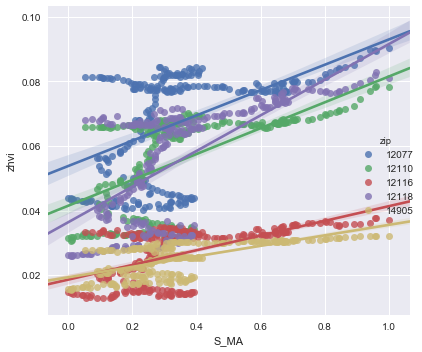

In [150]:
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], 
           x = 'S_MA', y = 'zhvi', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24']:
        temp = allhomes_allzips4[allhomes_allzips4.zip == zipcode][[col, 'zhvi']]
        print('{} v. zhvi: '.format(col), pearsonr(allhomes_allzips4['zhvi'], allhomes_allzips4[col]))

all zips


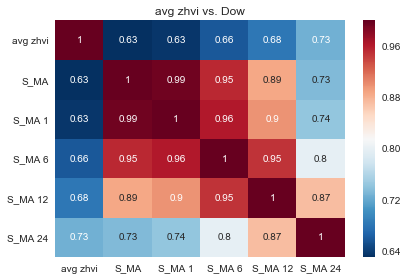

zip: 14905


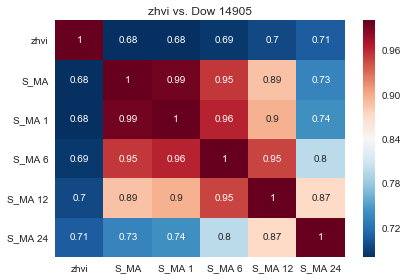

zip: 12077


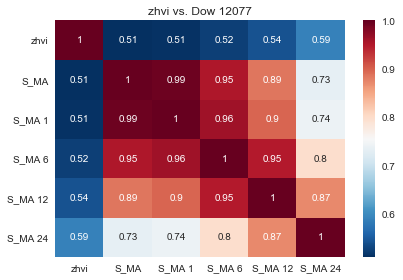

zip: 12118


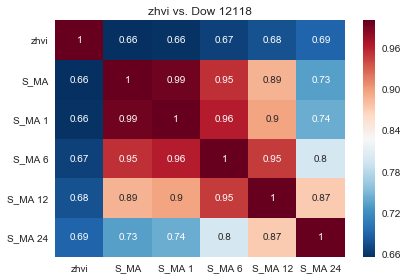

zip: 12116


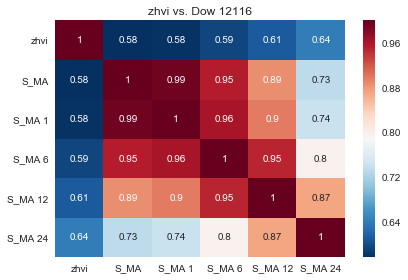

zip: 12110


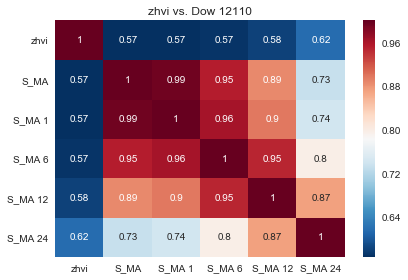

In [153]:
temp = allhomes_allzips4[['S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24', 'zhvi']]
temp['id'] = temp.index

temp['avg zhvi'] = temp.groupby(['id'])['zhvi'].mean()
temp = temp[['S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24', 'avg zhvi']].drop_duplicates()

print('all zips')
heatmap1 = temp[['avg zhvi', 'S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('avg zhvi vs. Dow')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi', 'S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. Dow ' + zipcode)
    plt.tight_layout()
    plt.show()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


S_MA pct_change v. zhvi % change:  (0.027128441178858917, 0.6614338395037306)
S_MA pct_change 1 v. zhvi % change:  (-0.007346681877732848, 0.9056102929660389)
S_MA pct_change 6 v. zhvi % change:  (0.008061587416071226, 0.8964743704016519)
S_MA pct_change 12 v. zhvi % change:  (-0.022980265780761955, 0.7106739437778735)
S_MA pct_change 24 v. zhvi % change:  (0.0037269440015827164, 0.9520336297416464)


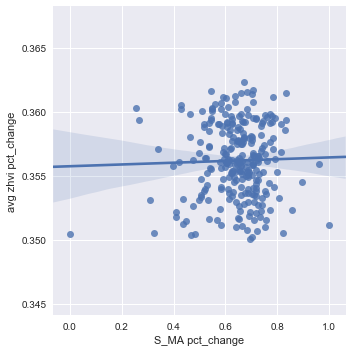

In [158]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 
                          'S_MA pct_change 24', 'zhvi pct_change']]
temp['id'] = temp.index

temp['avg zhvi pct_change'] = temp.groupby(['id'])['zhvi pct_change'].mean()
temp = temp[['S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12',
             'S_MA pct_change 24', 'avg zhvi pct_change']].drop_duplicates()


sns.lmplot(data = temp, x = 'S_MA pct_change', y = 'avg zhvi pct_change')
plt.tight_layout()
for col in ['S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']:
    print('{} v. zhvi % change: '.format(col), pearsonr(temp['avg zhvi pct_change'], temp[col]))

14905
S_MA pct_change v. zhvi % change:  (0.0062249864450887185, 0.0034995518880109916)
S_MA pct_change 1 v. zhvi % change:  (0.0006328580552911906, 0.7665707875308757)
S_MA pct_change 6 v. zhvi % change:  (0.003915388390780701, 0.06626130932624914)
S_MA pct_change 12 v. zhvi % change:  (-0.002498599861242662, 0.2411752762234246)
S_MA pct_change 24 v. zhvi % change:  (0.001885063156039394, 0.3765595725006693)
12077
S_MA pct_change v. zhvi % change:  (0.0062249864450887185, 0.0034995518880109916)
S_MA pct_change 1 v. zhvi % change:  (0.0006328580552911906, 0.7665707875308757)
S_MA pct_change 6 v. zhvi % change:  (0.003915388390780701, 0.06626130932624914)
S_MA pct_change 12 v. zhvi % change:  (-0.002498599861242662, 0.2411752762234246)
S_MA pct_change 24 v. zhvi % change:  (0.001885063156039394, 0.3765595725006693)
12118
S_MA pct_change v. zhvi % change:  (0.0062249864450887185, 0.0034995518880109916)
S_MA pct_change 1 v. zhvi % change:  (0.0006328580552911906, 0.7665707875308757)
S_MA 

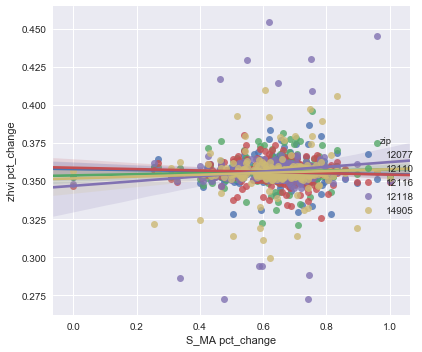

In [159]:
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], 
           x = 'S_MA pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']:
        temp = allhomes_allzips4[allhomes_allzips4.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi % change: '.format(col), pearsonr(allhomes_allzips4['zhvi pct_change'], allhomes_allzips4[col]))       

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


all zips


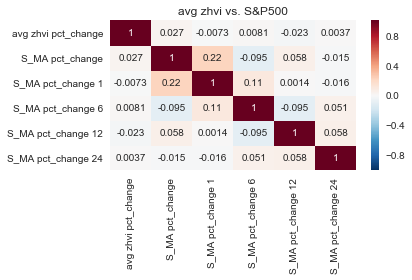

zip: 14905


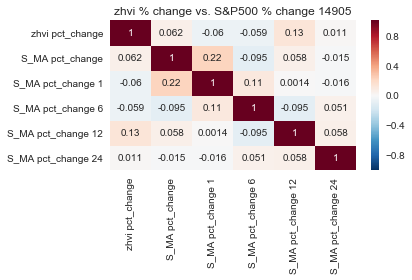

zip: 12077


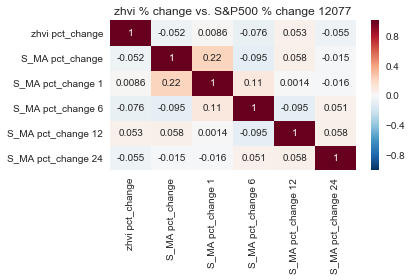

zip: 12118


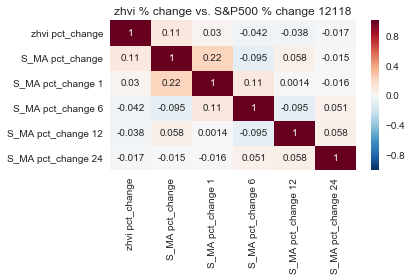

zip: 12116


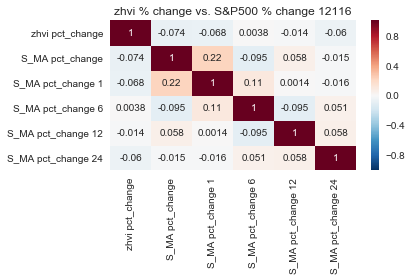

zip: 12110


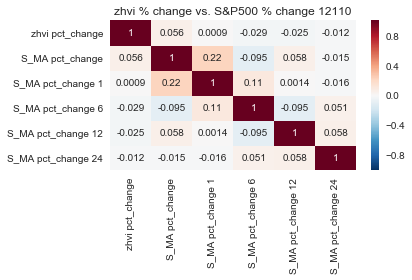

In [161]:
temp = allhomes_allzips4[['S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 
                          'S_MA pct_change 12', 'S_MA pct_change 24', 'zhvi pct_change']]
temp['id'] = temp.index

temp['avg zhvi pct_change'] = temp.groupby(['id'])['zhvi pct_change'].mean()
temp = temp[['S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 
             'S_MA pct_change 12', 'S_MA pct_change 24', 'avg zhvi pct_change']].drop_duplicates()


print('all zips')
heatmap1 = temp[['avg zhvi pct_change', 'S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('avg zhvi vs. S&P500')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi pct_change', 'S_MA pct_change', 'S_MA pct_change 1', 
                                                                    'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi % change vs. S&P500 % change ' + zipcode)
    plt.tight_layout()
    plt.show()

### NASDAQ

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


N_MA v. zhvi:  (0.5722846396013674, 2.7879803044953972e-24)
N_MA 1 v. zhvi:  (0.573891417214522, 1.943916778841132e-24)
N_MA 6 v. zhvi:  (0.5825710054989621, 2.6768663583887827e-25)
N_MA 12 v. zhvi:  (0.5921680910243166, 2.7867821905261025e-26)
N_MA 24 v. zhvi:  (0.6237427234748939, 9.309361326101312e-30)


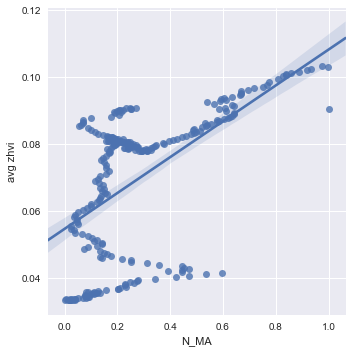

In [162]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24', 'zhvi']]
temp['id'] = temp.index

temp['avg zhvi'] = temp.groupby(['id'])['zhvi'].mean()
temp = temp[['N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24', 'avg zhvi']].drop_duplicates()


sns.lmplot(data = temp, x = 'N_MA', y = 'avg zhvi')
plt.tight_layout()
for col in ['N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24']:
    print('{} v. zhvi: '.format(col), pearsonr(temp['avg zhvi'], temp[col]))

14905
N_MA v. zhvi:  (0.15726908069637904, 0.0)
N_MA 1 v. zhvi:  (0.15772771654533088, 0.0)
N_MA 6 v. zhvi:  (0.16020030523838646, 0.0)
N_MA 12 v. zhvi:  (0.16277491409155648, 0.0)
N_MA 24 v. zhvi:  (0.1708639271022603, 0.0)
12077
N_MA v. zhvi:  (0.15726908069637904, 0.0)
N_MA 1 v. zhvi:  (0.15772771654533088, 0.0)
N_MA 6 v. zhvi:  (0.16020030523838646, 0.0)
N_MA 12 v. zhvi:  (0.16277491409155648, 0.0)
N_MA 24 v. zhvi:  (0.1708639271022603, 0.0)
12118
N_MA v. zhvi:  (0.15726908069637904, 0.0)
N_MA 1 v. zhvi:  (0.15772771654533088, 0.0)
N_MA 6 v. zhvi:  (0.16020030523838646, 0.0)
N_MA 12 v. zhvi:  (0.16277491409155648, 0.0)
N_MA 24 v. zhvi:  (0.1708639271022603, 0.0)
12116
N_MA v. zhvi:  (0.15726908069637904, 0.0)
N_MA 1 v. zhvi:  (0.15772771654533088, 0.0)
N_MA 6 v. zhvi:  (0.16020030523838646, 0.0)
N_MA 12 v. zhvi:  (0.16277491409155648, 0.0)
N_MA 24 v. zhvi:  (0.1708639271022603, 0.0)
12110
N_MA v. zhvi:  (0.15726908069637904, 0.0)
N_MA 1 v. zhvi:  (0.15772771654533088, 0.0)
N_MA 6 v

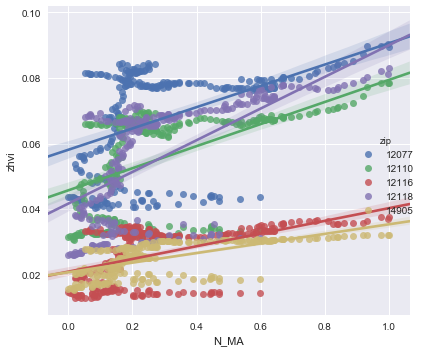

In [163]:
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], 
           x = 'N_MA', y = 'zhvi', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24']:
        temp = allhomes_allzips4[allhomes_allzips4.zip == zipcode][[col, 'zhvi']]
        print('{} v. zhvi: '.format(col), pearsonr(allhomes_allzips4['zhvi'], allhomes_allzips4[col]))

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


all zips


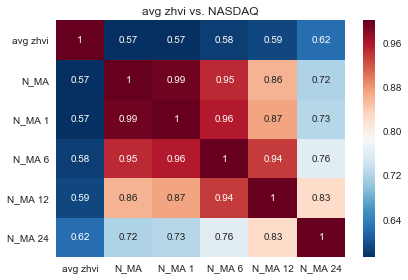

zip: 14905


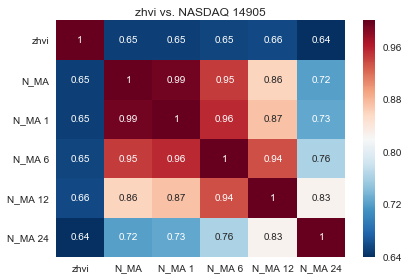

zip: 12077


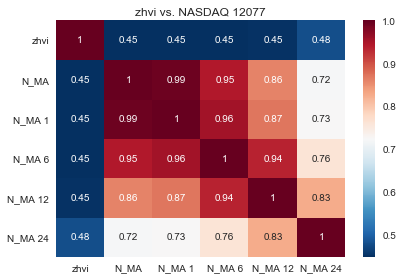

zip: 12118


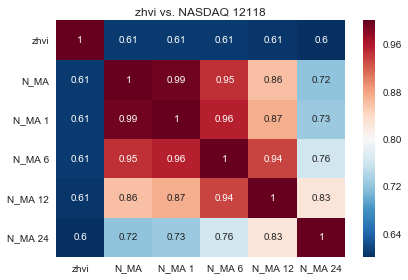

zip: 12116


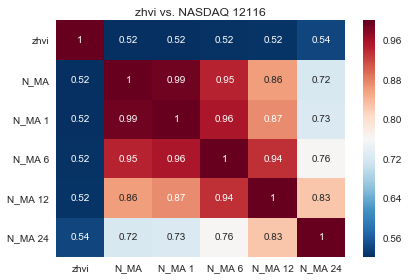

zip: 12110


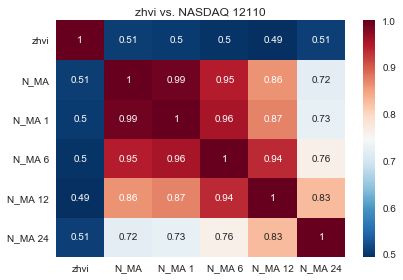

In [164]:
temp = allhomes_allzips4[['N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24', 'zhvi']]
temp['id'] = temp.index

temp['avg zhvi'] = temp.groupby(['id'])['zhvi'].mean()
temp = temp[['N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24', 'avg zhvi']].drop_duplicates()

print('all zips')
heatmap1 = temp[['avg zhvi', 'N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('avg zhvi vs. NASDAQ')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi', 'N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. NASDAQ ' + zipcode)
    plt.tight_layout()
    plt.show()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


N_MA pct_change v. zhvi % change:  (0.016286466326289398, 0.7926419546599482)
N_MA pct_change 1 v. zhvi % change:  (-0.009406430469839284, 0.8793262226299788)
N_MA pct_change 6 v. zhvi % change:  (0.003973467940427591, 0.9488650152068729)
N_MA pct_change 12 v. zhvi % change:  (-0.019959499388806475, 0.7473171185638448)
N_MA pct_change 24 v. zhvi % change:  (-0.00896671349100935, 0.8849272811441257)


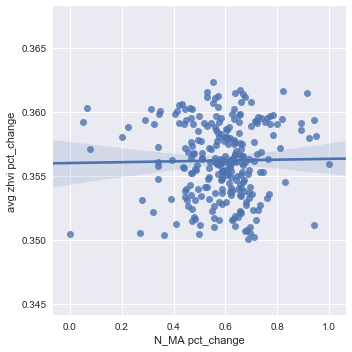

In [165]:
# for all zipcodes. what we should look at is an average
temp = allhomes_allzips4[['N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12', 
                          'N_MA pct_change 24', 'zhvi pct_change']]
temp['id'] = temp.index

temp['avg zhvi pct_change'] = temp.groupby(['id'])['zhvi pct_change'].mean()
temp = temp[['N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12',
             'N_MA pct_change 24', 'avg zhvi pct_change']].drop_duplicates()


sns.lmplot(data = temp, x = 'N_MA pct_change', y = 'avg zhvi pct_change')
plt.tight_layout()
for col in ['N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24']:
    print('{} v. zhvi % change: '.format(col), pearsonr(temp['avg zhvi pct_change'], temp[col]))

14905
N_MA pct_change v. zhvi % change:  (0.0037667987866982994, 0.07723658404144113)
N_MA pct_change 1 v. zhvi % change:  (-0.0004795732722812676, 0.8220103850909183)
N_MA pct_change 6 v. zhvi % change:  (0.0022289211625609283, 0.29576799320581665)
N_MA pct_change 12 v. zhvi % change:  (-0.0028128579610911192, 0.18701257538747704)
N_MA pct_change 24 v. zhvi % change:  (-0.0005498152533292489, 0.7964768435343808)
12077
N_MA pct_change v. zhvi % change:  (0.0037667987866982994, 0.07723658404144113)
N_MA pct_change 1 v. zhvi % change:  (-0.0004795732722812676, 0.8220103850909183)
N_MA pct_change 6 v. zhvi % change:  (0.0022289211625609283, 0.29576799320581665)
N_MA pct_change 12 v. zhvi % change:  (-0.0028128579610911192, 0.18701257538747704)
N_MA pct_change 24 v. zhvi % change:  (-0.0005498152533292489, 0.7964768435343808)
12118
N_MA pct_change v. zhvi % change:  (0.0037667987866982994, 0.07723658404144113)
N_MA pct_change 1 v. zhvi % change:  (-0.0004795732722812676, 0.8220103850909183

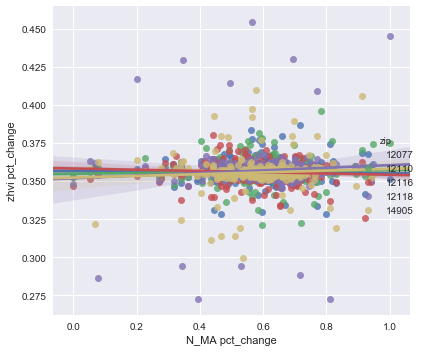

In [166]:
sns.lmplot(data = allhomes_allzips4[allhomes_allzips4.zip.isin(example_zips)], 
           x = 'N_MA pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24']:
        temp = allhomes_allzips4[allhomes_allzips4.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi % change: '.format(col), pearsonr(allhomes_allzips4['zhvi pct_change'], allhomes_allzips4[col]))       

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


all zips


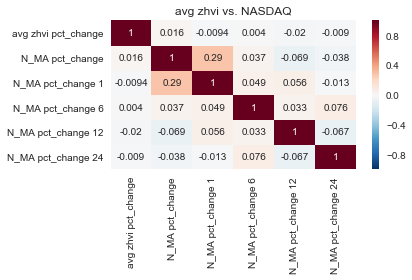

zip: 14905


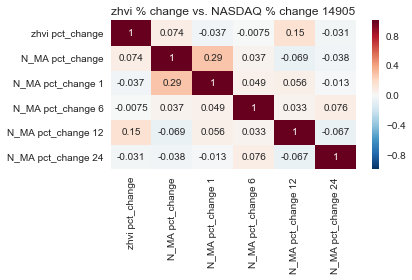

zip: 12077


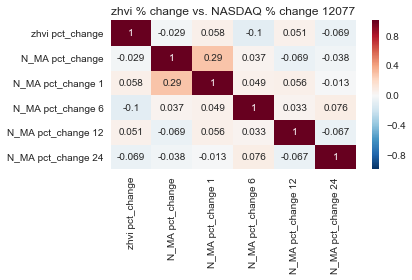

zip: 12118


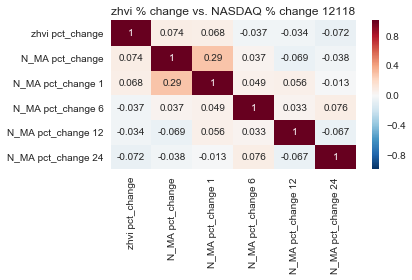

zip: 12116


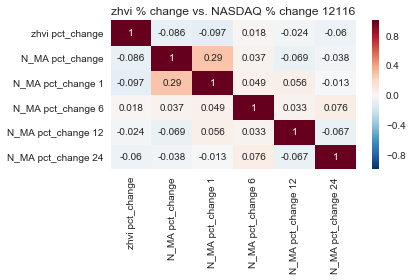

zip: 12110


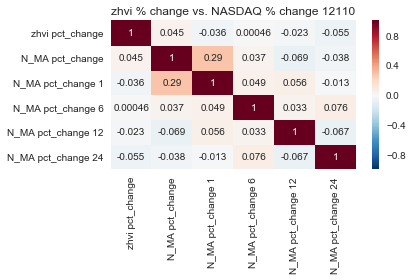

In [167]:
temp = allhomes_allzips4[['N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 
                          'N_MA pct_change 12', 'N_MA pct_change 24', 'zhvi pct_change']]
temp['id'] = temp.index

temp['avg zhvi pct_change'] = temp.groupby(['id'])['zhvi pct_change'].mean()
temp = temp[['N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 
             'N_MA pct_change 12', 'N_MA pct_change 24', 'avg zhvi pct_change']].drop_duplicates()


print('all zips')
heatmap1 = temp[['avg zhvi pct_change', 'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24']].corr()
sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
plt.yticks(rotation = 0) 
plt.title('avg zhvi vs. NASDAQ')
plt.tight_layout()
plt.show()

for zipcode in example_zips:
    print('zip: ' + zipcode)
    heatmap1 = allhomes_allzips4[allhomes_allzips4.zip == zipcode][['zhvi pct_change', 'N_MA pct_change', 'N_MA pct_change 1', 
                                                                    'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi % change vs. NASDAQ % change ' + zipcode)
    plt.tight_layout()
    plt.show()

### Summarize zhvi by year, and merge with yearly data

### Manipulate the dataset to get an annual summary

In [170]:
allhomes_allzips4['year'] = allhomes_allzips4.index.year
allhomes_allzips_annual = allhomes_allzips4[allhomes_allzips4.index.month == 1]
#not sure why pct_change didn't work
allhomes_allzips_annual['zhvi pct_change'] = allhomes_allzips_annual['zhvi'] / allhomes_allzips_annual.groupby(['zip'])['zhvi'].shift(1) - 1
print('old shape: {}'.format(allhomes_allzips4.shape))
print('new shape: {}'.format(allhomes_allzips_annual.shape))
#temp1_df_annual[temp1_df_annual.zip == '12077'].head(25)
allhomes_allzips_annual.head(25)

old shape: (220042, 56)
new shape: (18450, 56)


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


zhvi  zhvi pct_change  30 FRM Rate  30 FRM Rate 1  \
2008-01-01  0.339931              NaN     0.466156       0.531920   
2009-01-01  0.355847         0.046819     0.328827       0.375248   
2010-01-01  0.340417        -0.043362     0.324958       0.305616   
2011-01-01  0.324275        -0.047418     0.272735       0.263063   
2012-01-01  0.294158        -0.092873     0.110260       0.117997   
2013-01-01  0.311918         0.060373     0.011615       0.000010   
2014-01-01  0.361799         0.159918     0.208905       0.214708   
2015-01-01  0.388454         0.073674     0.061905       0.098655   
2016-01-01  0.436879         0.124662     0.101073       0.117997   
2017-01-01  0.457162         0.046426     0.154747       0.164418   
2018-01-01  0.440988        -0.035380     0.131537       0.116063   
2008-01-01  0.300110              NaN     0.466156       0.531920   
2009-01-01  0.309136         0.030073     0.328827       0.375248   
2010-01-01  0.288886        -0.065506     0.324958       0.305616   
2011-01-01  0.282642        -0.021611     0.272735       0.263063   
2012-01-01  0.284421         0.006295     0.110260       0.117997   
2013-01-01  0.299302         0.052318     0.011615       0.000010   
2014-01-01  0.316899         0.058795     0.208905       0.214708   
2015-01-01  0.355523         0.121881     0.061905       0.098655   
2016-01-01  0.375612         0.056504     0.101073       0.117997   
2017-01-01  0.400585         0.066486     0.154747       0.164418   
2018-01-01  0.396703        -0.009690     0.131537       0.116063   
2008-01-01  0.234152              NaN     0.466156       0.531920   
2009-01-01  0.245700         0.049320     0.328827       0.375248   
2010-01-01  0.190644        -0.224082     0.324958       0.305616   

            30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
2008-01-01       0.647973        0.555130        0.478638   
2009-01-01       0.595749        0.466156        0.490603   
2010-01-01       0.361709        0.328827        0.411972   
2011-01-01       0.234050        0.324958        0.290605   
2012-01-01       0.232116        0.272735        0.287187   
2013-01-01       0.038694        0.110260        0.241033   
2014-01-01       0.197300        0.011615        0.097445   
2015-01-01       0.150879        0.208905        0.010266   
2016-01-01       0.134631        0.061905        0.184624   
2017-01-01       0.017418        0.101073        0.054710   
2018-01-01       0.119931        0.154747        0.089325   
2008-01-01       0.647973        0.555130        0.478638   
2009-01-01       0.595749        0.466156        0.490603   
2010-01-01       0.361709        0.328827        0.411972   
2011-01-01       0.234050        0.324958        0.290605   
2012-01-01       0.232116        0.272735        0.287187   
2013-01-01       0.038694        0.110260        0.241033   
2014-01-01       0.197300        0.011615        0.097445   
2015-01-01       0.150879        0.208905        0.010266   
2016-01-01       0.134631        0.061905        0.184624   
2017-01-01       0.017418        0.101073        0.054710   
2018-01-01       0.119931        0.154747        0.089325   
2008-01-01       0.647973        0.555130        0.478638   
2009-01-01       0.595749        0.466156        0.490603   
2010-01-01       0.361709        0.328827        0.411972   

            30 FRM Rate pct_change  30 FRM Rate pct_change 1  \
2008-01-01                0.269059                  0.404337   
2009-01-01                0.305949                  0.000010   
2010-01-01                0.539519                  0.503807   
2011-01-01                0.505122                  0.806574   
2012-01-01                0.431419                  0.440606   
2013-01-01                0.531075                  0.467355   
2014-01-01                0.443425                  0.634382   
2015-01-01                0.292237                  0.342837   
2016-01-01                0.388745                  0.4854

In [171]:
census_stacked1 = census[['ZIP Code', '2000', '2010', '2011', '2012', '2013', '2014', '2015', '2016']]
census_stacked2 = census[['ZIP Code', '2000_pop_density', '2010_pop_density', '2011_pop_density', '2012_pop_density', 
                          '2013_pop_density', '2014_pop_density', '2015_pop_density', '2016_pop_density']]
census_stacked1.columns = ['zip', 2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
census_stacked2.columns = ['zip', 2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
census_stacked1.set_index('zip', inplace = True)
census_stacked2.set_index('zip', inplace = True)
census_stacked1.head()

2000     2010     2011     2012     2013     2014     2015     2016
zip                                                                          
12046    934.0    817.0    973.0    891.0    907.0    772.0    855.0    966.0
12083   3153.0   3789.0   3742.0   3670.0   3736.0   3639.0   3594.0   3673.0
12085      NaN    359.0    475.0    492.0    523.0    507.0    601.0    520.0
12201      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
12203  25604.0  26464.0  29441.0  30078.0  30505.0  30926.0  30518.0  30625.0

In [172]:
census_stacked1 = census_stacked1.stack().reset_index().rename(columns = {'level_1' : 'year', 0: 'pop'})
census_stacked2 = census_stacked2.stack().reset_index().rename(columns = {'level_1' : 'year', 0: 'pop dens'})
print(census_stacked2.head(20))

      zip  year     pop dens
0   12046  2000    23.495252
1   12046  2010    20.552057
2   12046  2011    24.476317
3   12046  2012    22.413565
4   12046  2013    22.816053
5   12046  2014    19.420059
6   12046  2015    21.507967
7   12046  2016    24.300229
8   12083  2000    28.233022
9   12083  2010    33.927980
10  12083  2011    33.507126
11  12083  2012    32.862414
12  12083  2013    33.453400
13  12083  2014    32.584830
14  12083  2015    32.181884
15  12083  2016    32.889277
16  12085  2010   789.488152
17  12085  2011  1044.587388
18  12085  2012  1081.972621
19  12085  2013  1150.145692


In [198]:
print(irs_zip_summary.head())

      STATE ZIPCODE  year   num R       avg AGI        avg SW        avg OI  \
10743    MA   01001  2009  8565.0  49750.379451  38775.948628   9908.347928   
10733    MA   01001  2010  8608.0  50656.482342  38910.432156  10304.019517   
10750    MA   01001  2011  8655.0  51325.014443  39499.595609  10562.333911   
10723    MA   01001  2012  8780.0  52245.558087  40033.029613  11148.405467   
10721    MA   01001  2013  8780.0  53751.252847  40881.890661  11619.589977   

        num R z  avg AGI z  avg SW z  avg OI z  num R pchg  avg AGI pchg  \
10743  0.425801  -0.243336 -0.100825 -0.205216         NaN           NaN   
10733  0.431409  -0.224621 -0.094460 -0.189778    0.005020      0.018213   
10750  0.437540  -0.210812 -0.066576 -0.179700    0.005460      0.013197   
10723  0.453843  -0.191799 -0.041330 -0.156834    0.014443      0.017936   
10721  0.453843  -0.160699 -0.001155 -0.138450    0.000000      0.028820   

       avg OI pchg  avg SW pchg  
10743          NaN          NaN  


In [199]:
annual_stacked = pd.merge(allhomes_allzips_annual, census_stacked1, how = 'left', left_on = ['zip', 'year'], right_on = ['zip', 'year'])
annual_stacked = pd.merge(annual_stacked, census_stacked2, how = 'left', left_on = ['zip', 'year'], right_on = ['zip', 'year'])
annual_stacked = pd.merge(annual_stacked, irs_zip_summary[['num R', 'avg AGI', 'avg SW', 'avg OI', 
                                                           'num R z', 'avg AGI z', 'avg SW z', 'avg OI z', 'ZIPCODE', 'year']], how = 'left', left_on = ['zip', 'year'], right_on = ['ZIPCODE', 'year'])
annual_stacked.drop(['ZIPCODE'], axis = 1, inplace = True)

#note that we need to shift census data by 2 years
for col in ['pop', 'pop dens']:
    annual_stacked[col + ' shift2'] = annual_stacked.groupby(['zip'])[col].shift(2)

#note that we need to shift irs data by 3 years
for col in ['num R', 'avg AGI', 'avg SW', 'avg OI', 'num R z', 'avg AGI z', 'avg SW z', 'avg OI z']:
    annual_stacked[col + ' shift3'] = annual_stacked.groupby(['zip'])[col].shift(3)

print(annual_stacked.shape) #(23919, 15)
#annual_stacked[annual_stacked.zip == '12077'].head(30)
print(annual_stacked.columns)
annual_stacked.head(30)

(23899, 76)
Index(['zhvi', 'zhvi pct_change', '30 FRM Rate', '30 FRM Rate 1',
       '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24',
       '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
       '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
       '30 FRM Rate pct_change 24', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6',
       'Fed Rate 12', 'Fed Rate 24', 'Fed Rate pct_change',
       'Fed Rate pct_change 1', 'Fed Rate pct_change 6',
       'Fed Rate pct_change 12', 'Fed Rate pct_change 24', 'D_MA', 'N_MA',
       'S_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 'D_MA pct_change',
       'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12',
       'D_MA pct_change 24', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24',
       'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6',
       'N_MA pct_change 12', 'N_MA pct_change 24', 'S_MA 1', 'S_MA 6',
       'S_MA 12', 'S_MA 24', 'S_MA pct_change', 'S_MA pct_change 1',
       'S_MA pct_change 6', 'S_MA pct_chang

zhvi  zhvi pct_change  30 FRM Rate  30 FRM Rate 1  30 FRM Rate 6  \
0   0.339931              NaN     0.466156       0.531920       0.647973   
1   0.355847         0.046819     0.328827       0.375248       0.595749   
2   0.340417        -0.043362     0.324958       0.305616       0.361709   
3   0.324275        -0.047418     0.272735       0.263063       0.234050   
4   0.294158        -0.092873     0.110260       0.117997       0.232116   
5   0.311918         0.060373     0.011615       0.000010       0.038694   
6   0.361799         0.159918     0.208905       0.214708       0.197300   
7   0.388454         0.073674     0.061905       0.098655       0.150879   
8   0.436879         0.124662     0.101073       0.117997       0.134631   
9   0.457162         0.046426     0.154747       0.164418       0.017418   
10  0.440988        -0.035380     0.131537       0.116063       0.119931   
11  0.300110              NaN     0.466156       0.531920       0.647973   
12  0.309136         0.030073     0.328827       0.375248       0.595749   
13  0.288886        -0.065506     0.324958       0.305616       0.361709   
14  0.282642        -0.021611     0.272735       0.263063       0.234050   
15  0.284421         0.006295     0.110260       0.117997       0.232116   
16  0.299302         0.052318     0.011615       0.000010       0.038694   
17  0.316899         0.058795     0.208905       0.214708       0.197300   
18  0.355523         0.121881     0.061905       0.098655       0.150879   
19  0.375612         0.056504     0.101073       0.117997       0.134631   
20  0.400585         0.066486     0.154747       0.164418       0.017418   
21  0.396703        -0.009690     0.131537       0.116063       0.119931   
22  0.234152              NaN     0.466156       0.531920       0.647973   
23  0.245700         0.049320     0.328827       0.375248       0.595749   
24  0.190644        -0.224082     0.324958       0.305616       0.361709   
25  0.180454        -0.053449     0.272735       0.263063       0.234050   
26  0.205588         0.139286     0.110260       0.117997       0.232116   
27  0.218625         0.063410     0.011615       0.000010       0.038694   
28  0.243274         0.112748     0.208905       0.214708       0.197300   
29  0.273520         0.124328     0.061905       0.098655       0.150879   

    30 FRM Rate 12  30 FRM Rate 24  30 FRM Rate pct_change  \
0         0.555130        0.478638                0.269059   
1         0.466156        0.490603                0.305949   
2         0.328827        0.411972                0.539519   
3         0.324958        0.290605                0.505122   
4         0.272735        0.287187                0.431419   
5         0.110260        0.241033                0.531075   
6         0.011615        0.097445                0.443425   
7         0.208905        0.010266                0.292237   
8         0.061905        0.184624                0.388745   
9         0.101073        0.054710                0.425002   
10        0.154747        0.089325                0.539409   
11        0.555130        0.478638                0.269059   
12        0.466156        0.490603                0.305949   
13        0.328827        0.411972                0.539519   
14        0.324958        0.290605                0.505122   
15        0.272735        0.287187                0.431419   
16        0.110260        0.241033                0.531075   
17        0.011615        0.097445                0.443425   
18        0.208905        0.010266                0.292237   
19        0.061905        0.184624                0.388745   
20        0.101073        0.054710                0.425002   
21        0.154747        0.089325                0.539409   
22        0.555130        0.478638                0.269059   
23        0.466156        0.490603                0.305949   
24        0.328827        0.411972                0.539519   
25        0.324958        0.290605     

pop shift2


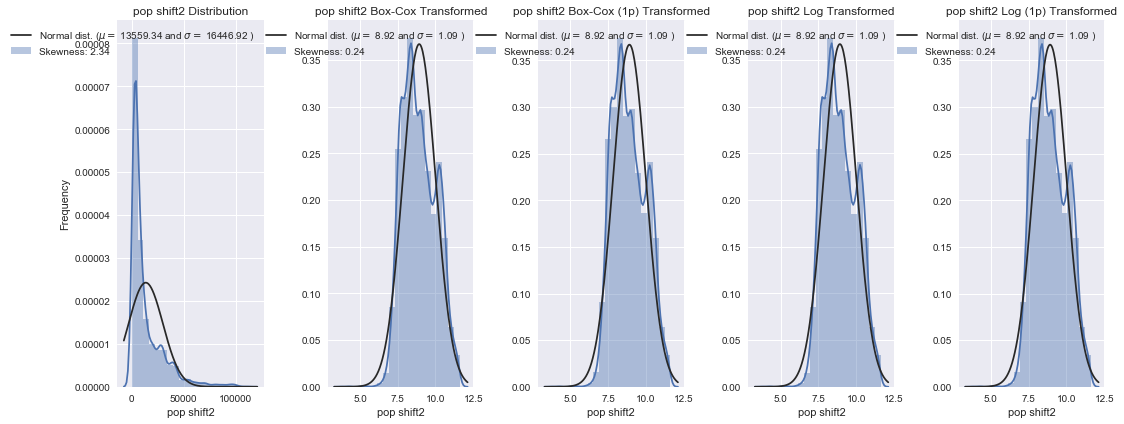

pop dens shift2


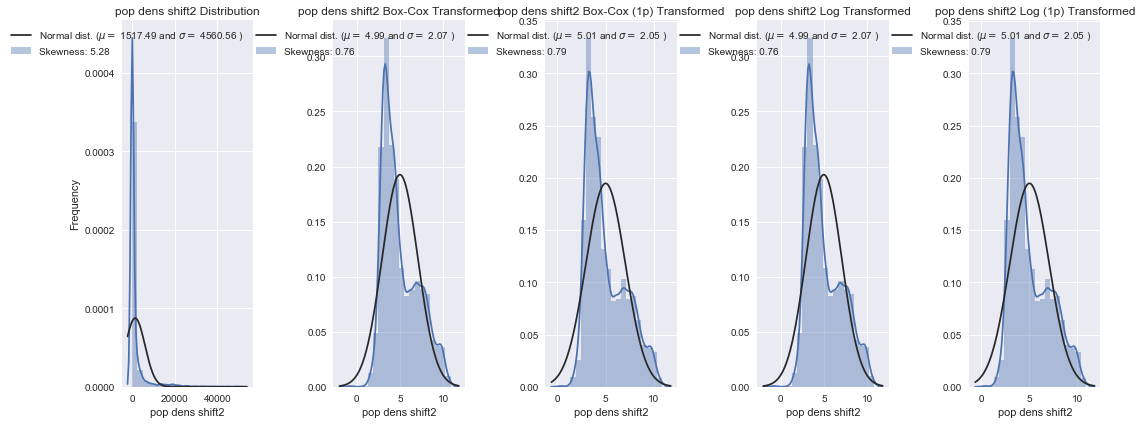

num R shift3


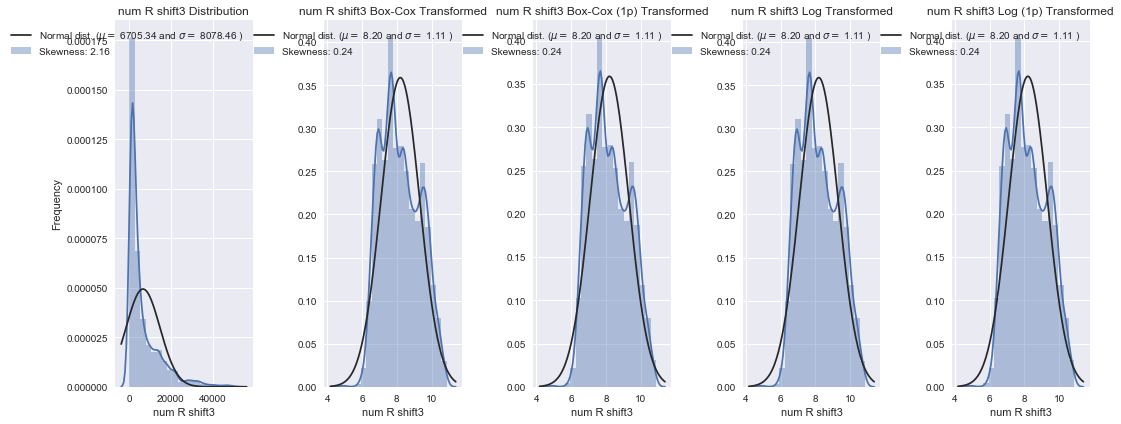

avg AGI shift3


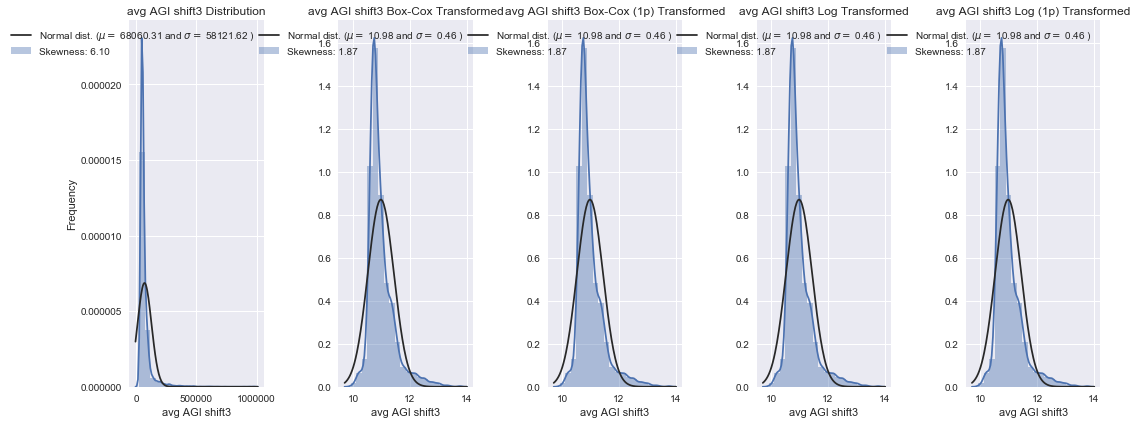

avg SW shift3


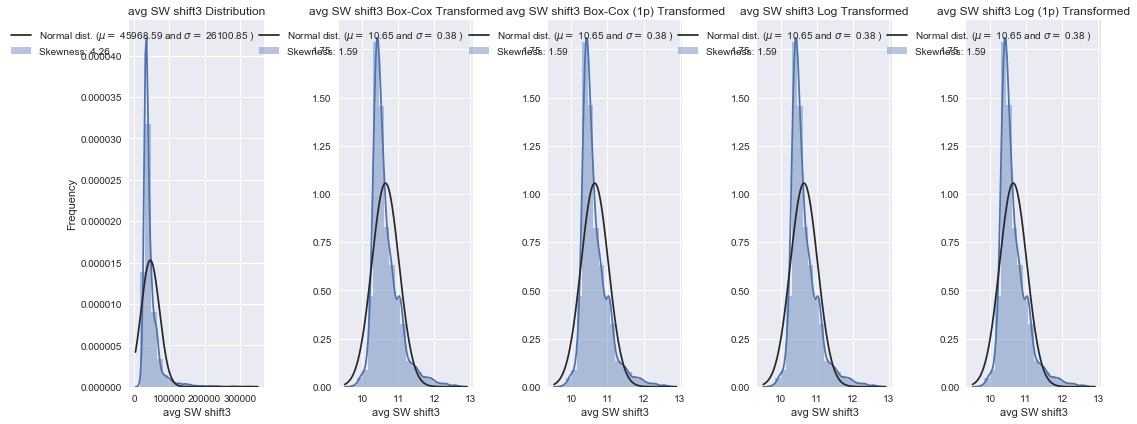

avg OI shift3


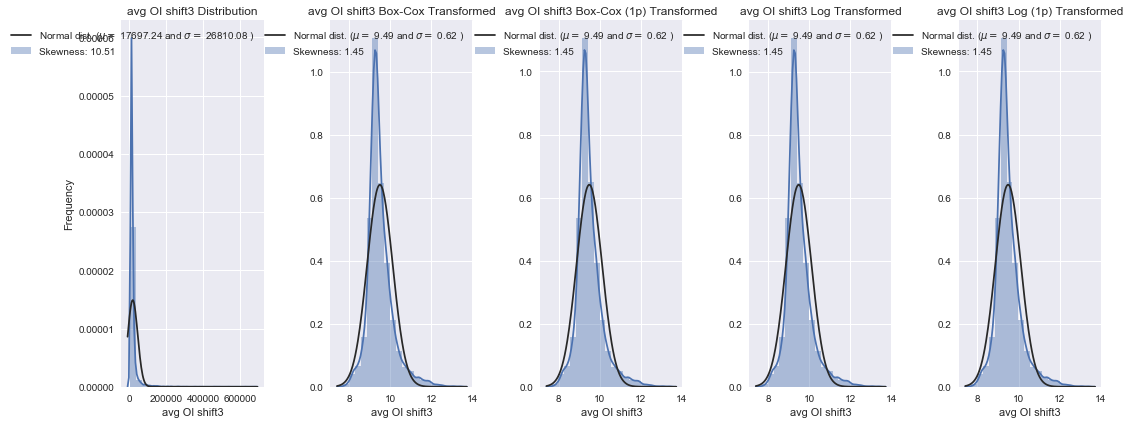

In [200]:
#Feature: some annual columns, trying to correct for skewness
for col in ['pop shift2', 'pop dens shift2', 'num R shift3', 'avg AGI shift3', 'avg SW shift3', 'avg OI shift3']:
    print(col)
    distribution_illustration(0, annual_stacked[col].dropna(), col)

num R z shift3
-0.676985043242696 6.126246206432486


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

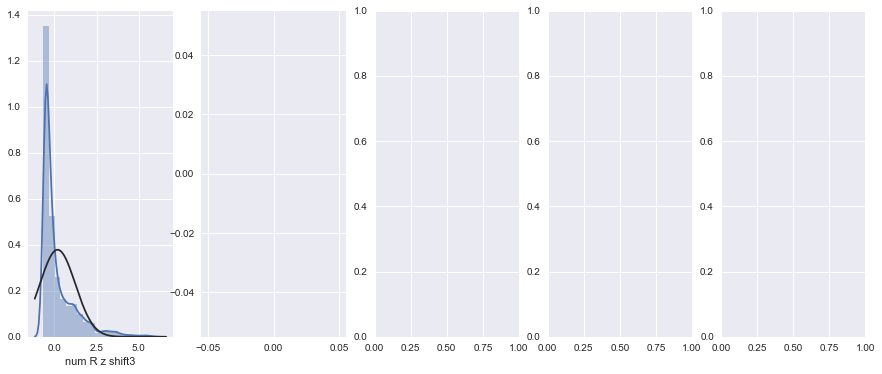

In [202]:
#Feature: some annual columns, trying to correct for skewness
for col in ['num R z shift3', 'avg AGI z shift3', 'avg SW z shift3', 'avg OI z shift3']:
    print(col)
    print(annual_stacked[col].dropna().min(), annual_stacked[col].dropna().max())
    distribution_illustration(0.0001, annual_stacked[col].dropna(), col)

feature names: pop


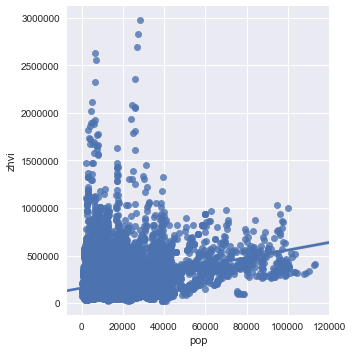

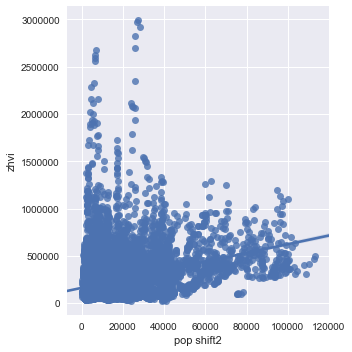

pop v. zhvi:  (0.3181984289166549, 1.7984493197113852e-296)
pop shift2 v. zhvi:  (0.3352022341135479, 0.0)


feature names: pop dens


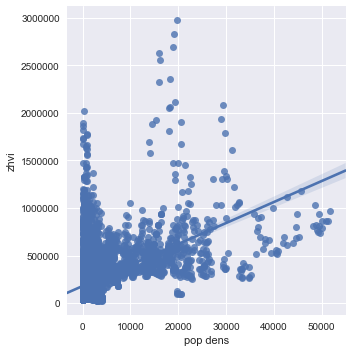

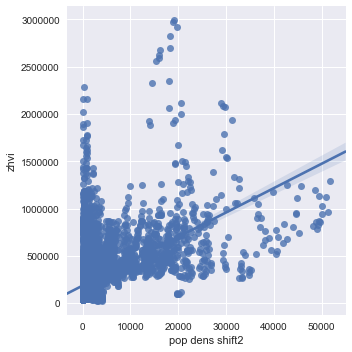

pop dens v. zhvi:  (0.4890591035408136, 0.0)
pop dens shift2 v. zhvi:  (0.5196491600233929, 0.0)


feature names: num R z


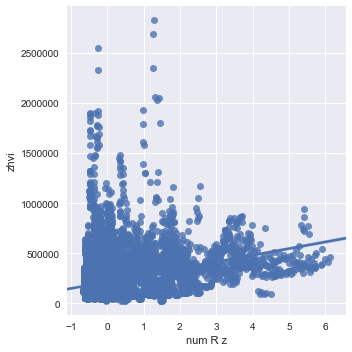

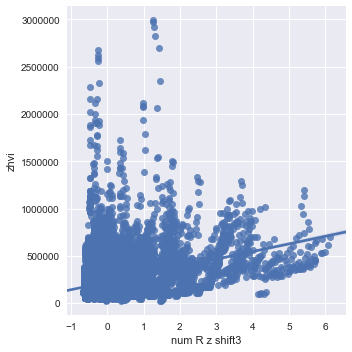

num R z v. zhvi:  (0.3332993118945623, 9.590597996389982e-273)
num R z shift3 v. zhvi:  (0.3584952816545137, 5.226014e-318)


feature names: avg AGI z


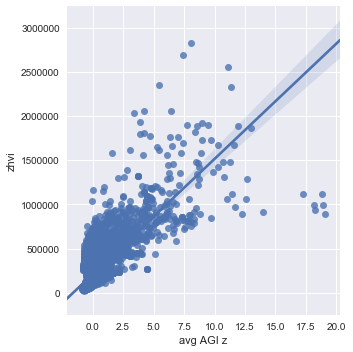

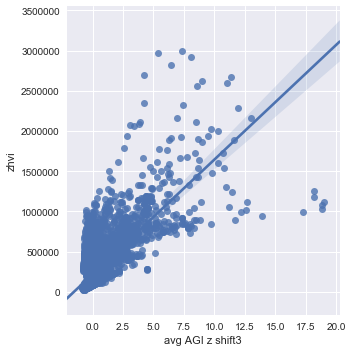

avg AGI z v. zhvi:  (0.7459007637640614, 0.0)
avg AGI z shift3 v. zhvi:  (0.7207689931194635, 0.0)


feature names: avg SW z


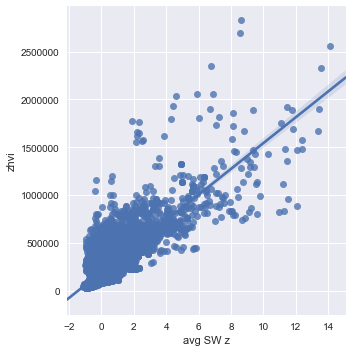

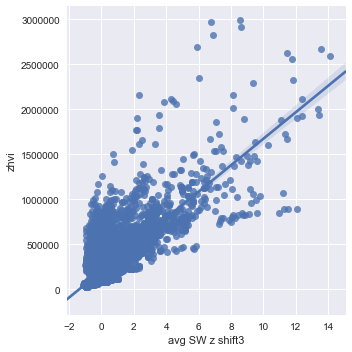

avg SW z v. zhvi:  (0.7932538494821707, 0.0)
avg SW z shift3 v. zhvi:  (0.7662870266020807, 0.0)


feature names: avg OI z


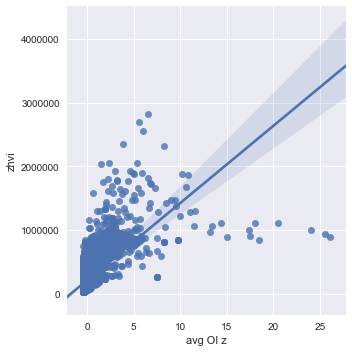

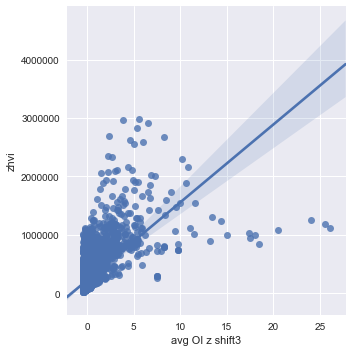

avg OI z v. zhvi:  (0.60291834230506, 0.0)
avg OI z shift3 v. zhvi:  (0.5865373584323376, 0.0)




In [369]:
for col in zip(['pop', 'pop dens', 'num R z', 'avg AGI z', 'avg SW z', 'avg OI z'],
               [' shift2', ' shift2', ' shift3', ' shift3', ' shift3', ' shift3']):
    print('feature names: {}'.format(col[0]))
    allzips1 = annual_stacked[[col[0], 'zhvi', 'zip']].dropna()
    allzips2 = annual_stacked[[col[0] + col[1], 'zhvi', 'zip']].dropna()
    #fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,6))
    sns.lmplot(data = allzips1, x = col[0], y = 'zhvi')
    sns.lmplot(data = allzips2, x = col[0] + col[1], y = 'zhvi')
    plt.tight_layout()
    plt.show()

    print('{} v. zhvi: '.format(col[0]), pearsonr(allzips1['zhvi'], allzips1[col[0]]))
    print('{} v. zhvi: '.format(col[0] + col[1]), pearsonr(allzips2['zhvi'], allzips2[col[0] + col[1]]))
    print('\n')

feature names: pop


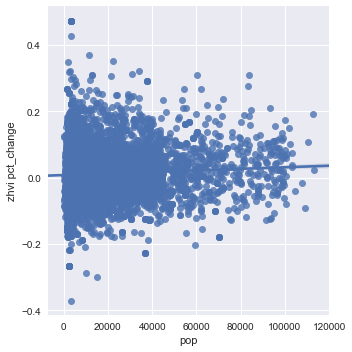

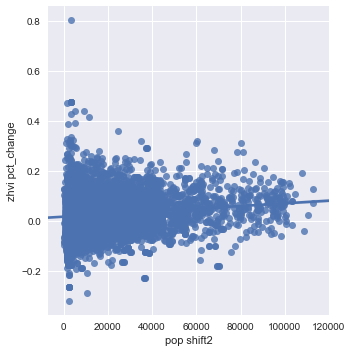

pop v. zhvi pct_change:  (0.06264158028174972, 1.712086762360705e-12)
pop shift2 v. zhvi pct_change:  (0.1401897379025905, 1.1435276799385552e-56)


feature names: pop dens


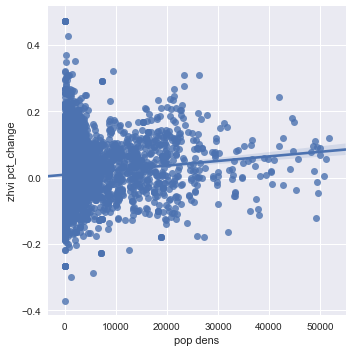

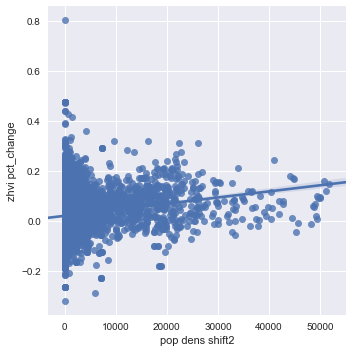

pop dens v. zhvi pct_change:  (0.10207432801736316, 1.0864273955017728e-30)
pop dens shift2 v. zhvi pct_change:  (0.17819457949758136, 5.805850044478077e-91)


feature names: num R z


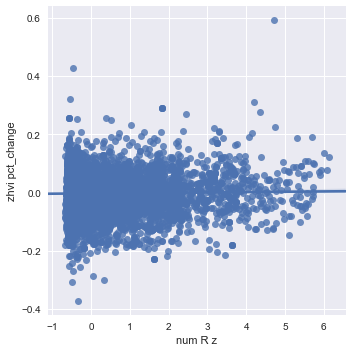

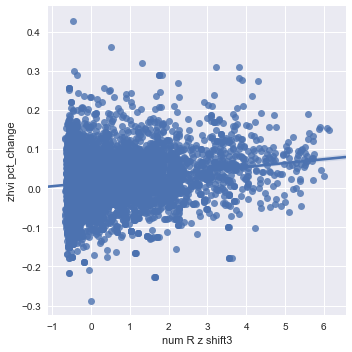

num R z v. zhvi pct_change:  (0.020572800068767588, 0.034792424374790305)
num R z shift3 v. zhvi pct_change:  (0.18859386283751883, 3.3197826247373764e-85)


feature names: avg AGI z


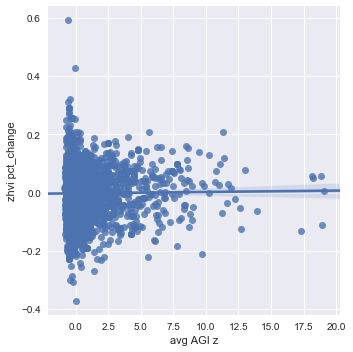

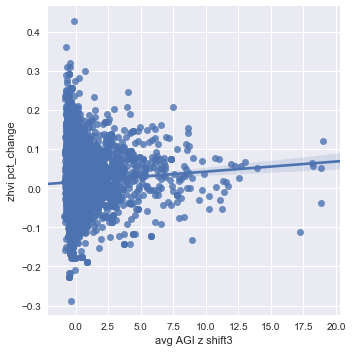

avg AGI z v. zhvi pct_change:  (0.00991855606132168, 0.3088872785797301)
avg AGI z shift3 v. zhvi pct_change:  (0.05639673852358869, 6.5700684282396555e-09)


feature names: avg SW z


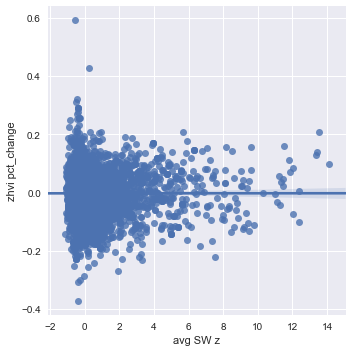

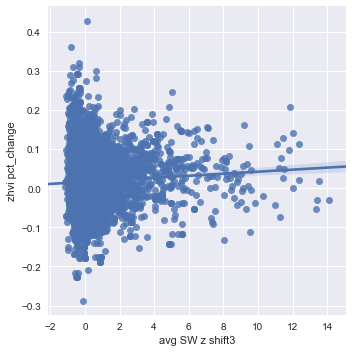

avg SW z v. zhvi pct_change:  (0.00029814432720311266, 0.9755994482578958)
avg SW z shift3 v. zhvi pct_change:  (0.05826620566253834, 2.0449543555316175e-09)


feature names: avg OI z


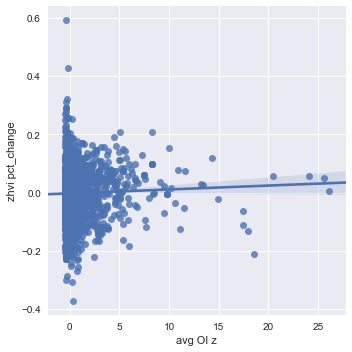

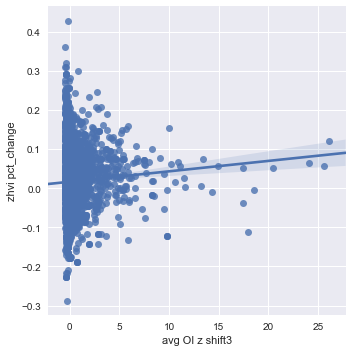

avg OI z v. zhvi pct_change:  (0.024610899382880573, 0.011563586604269538)
avg OI z shift3 v. zhvi pct_change:  (0.050490003293619135, 2.0681015393774479e-07)




In [396]:
for col in zip(['pop', 'pop dens', 'num R z', 'avg AGI z', 'avg SW z', 'avg OI z'],
               [' shift2', ' shift2', ' shift3', ' shift3', ' shift3', ' shift3']):
    print('feature names: {}'.format(col[0]))
    allzips1 = annual_stacked[[col[0], 'zhvi pct_change', 'zip']].dropna()
    allzips2 = annual_stacked[[col[0] + col[1], 'zhvi pct_change', 'zip']].dropna()
    #fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,6))
    sns.lmplot(data = allzips1, x = col[0], y = 'zhvi pct_change')
    sns.lmplot(data = allzips2, x = col[0] + col[1], y = 'zhvi pct_change')
    plt.tight_layout()
    plt.show()

    print('{} v. zhvi pct_change: '.format(col[0]), pearsonr(allzips1['zhvi pct_change'], allzips1[col[0]]))
    print('{} v. zhvi pct_change: '.format(col[0] + col[1]), pearsonr(allzips2['zhvi pct_change'], allzips2[col[0] + col[1]]))
    print('\n')

### PCA?

In [488]:
temp1_df.shape

(1320, 4)

### Monthly

In [481]:
ind = ~temp3_df[temp3_df['Home Type'] == 'All Homes'][['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', 
                                                       '30 FRM Rate 24', '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
                                                       '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12', 
                                                       '30 FRM Rate pct_change 24', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6',
                                                       'Fed Rate 12', 'Fed Rate 24', 'Fed Rate pct_change', 'Fed Rate pct_change 1', 
                                                       'Fed Rate pct_change 6', 'Fed Rate pct_change 12', 'Fed Rate pct_change 24', 
                                                       'D_MA', 'N_MA', 'S_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 
                                                       'D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12',
                                                       'D_MA pct_change 24', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24', 
                                                       'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12',
                                                       'N_MA pct_change 24', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24', 'S_MA pct_change',
                                                       'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']].isnull().any(axis = 1)

train_month = temp3_df[ind][['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12',
                             '30 FRM Rate 24', '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
                             '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
                             '30 FRM Rate pct_change 24', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6',
                             'Fed Rate 12', 'Fed Rate 24', 'Fed Rate pct_change', 'Fed Rate pct_change 1',
                             'Fed Rate pct_change 6', 'Fed Rate pct_change 12', 'Fed Rate pct_change 24',
                             'D_MA', 'N_MA', 'S_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24',
                             'D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12',
                             'D_MA pct_change 24', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24',
                             'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12',
                             'N_MA pct_change 24', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24', 'S_MA pct_change',
                             'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']]

ytrain1_month = temp3_df[ind]['zhvi']
ytrain2_month = temp3_df[ind]['zhvi pct_change']

print(train_month.shape)
train_month.head()

(1315, 50)


30 FRM Rate  30 FRM Rate 1  30 FRM Rate 6  30 FRM Rate 12  \
1996-05-01      0.91296       0.884914       0.779016        0.891684   
1996-05-01      0.91296       0.884914       0.779016        0.891684   
1996-05-01      0.91296       0.884914       0.779016        0.891684   
1996-05-01      0.91296       0.884914       0.779016        0.891684   
1996-05-01      0.91296       0.884914       0.779016        0.891684   

            30 FRM Rate 24  30 FRM Rate pct_change  30 FRM Rate pct_change 1  \
1996-05-01        0.897437                0.532448                  0.607814   
1996-05-01        0.897437                0.532448                  0.607814   
1996-05-01        0.897437                0.532448                  0.607814   
1996-05-01        0.897437                0.532448                  0.607814   
1996-05-01        0.897437                0.532448                  0.607814   

            30 FRM Rate pct_change 6  30 FRM Rate pct_change 12  \
1996-05-01                  0.420951                   0.313418   
1996-05-01                  0.420951                   0.313418   
1996-05-01                  0.420951                   0.313418   
1996-05-01                  0.420951                   0.313418   
1996-05-01                  0.420951                   0.313418   

            30 FRM Rate pct_change 24         ...          N_MA pct_change 24  \
1996-05-01                   0.588853         ...                    0.546987   
1996-05-01                   0.588853         ...                    0.546987   
1996-05-01                   0.588853         ...                    0.546987   
1996-05-01                   0.588853         ...                    0.546987   
1996-05-01                   0.588853         ...                    0.546987   

              S_MA 1   S_MA 6  S_MA 12  S_MA 24  S_MA pct_change  \
1996-05-01  0.001848  0.00001  0.00001  0.00001         0.689586   
1996-05-01  0.001848  0.00001  0.00001  0.00001         0.689586   
1996-05-01  0.001848  0.00001  0.00001  0.00001         0.689586   
1996-05-01  0.001848  0.00001  0.00001  0.00001         0.689586   
1996-05-01  0.001848  0.00001  0.00001  0.00001         0.689586   

            S_MA pct_change 1  S_MA pct_change 6  S_MA pct_change 12  \
1996-05-01           0.624353           0.690854            0.719746   
1996-05-01           0.624353           0.690854            0.719746   
1996-05-01           0.624353           0.690854            0.719746   
1996-05-01           0.624353           0.690854            0.719746   
1996-05-01           0.624353           0.690854            0.719746   

            S_MA pct_change 24  
1996-05-01            0.649465  
1996-05-01            0.649465  
1996-05-01            0.649465  
1996-05-01            0.649465  
1996-05-01            0.649465  

[5 rows x 50 columns]

In [486]:
pca_monthly = PCA(n_components = 5)
train_monthly_PCA = pd.DataFrame(pca_monthly.fit_transform(train_month))
print(train_monthly_PCA.shape)
print(pca_monthly)
print(pca_monthly.explained_variance_ratio_)

(1315, 5)
PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[0.59633899 0.14664174 0.05514233 0.0262144  0.02402371]


In [474]:
#let's do some visuzliation on pca
pca_results = vs.pca_results(train_monthly_PCA, pca_monthly)
plt.show()

ys = pca_monthly.explained_variance_ratio_
xs = np.arange(1, len(ys) + 1)
plt.plot(xs, np.cumsum(ys), '-o')
for label, x, y in zip(np.cumsum(ys), xs, np.cumsum(ys)):
    plt.annotate('{:.2f}%'.format(label * 100),
        xy = (x, y), xytext = (30, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Dimensions')
plt.title('PCA - Total Explained Variance by # fo Dimensions')
plt.tight_layout()
plt.show()

ValueError: Shape of passed values is (50, 5), indices imply (5, 5)

### Annual

In [434]:
ind = ~annual_stacked[['pop shift2', 'pop dens shift2', 'num R z shift3', 'avg AGI z shift3', 'avg SW z shift3', 'avg OI z shift3']].isnull().any(axis = 1)
train_annual = annual_stacked[ind][['pop shift2', 'pop dens shift2', 'num R z shift3', 'avg AGI z shift3', 'avg SW z shift3', 'avg OI z shift3']]
ytrain1_annual = annual_stacked[ind]['zhvi']
ytrain2_annual = annual_stacked[ind]['zhvi pct_change']
print(train_annual.shape) #(10568, 6)
train_annual.head()

(10568, 6)


pop shift2  pop dens shift2  num R z shift3  avg AGI z shift3  \
15      1219.0       336.324200       -0.611770          1.325582   
16      1206.0       332.737478       -0.610987          1.349213   
17      1207.0       333.013379       -0.605770          1.628203   
18      1217.0       335.772397       -0.606553          1.627795   
19      1073.0       296.042548       -0.606553          1.785375   

    avg SW z shift3  avg OI z shift3  
15         1.970626         0.360835  
16         2.034068         0.373724  
17         1.989886         0.304918  
18         2.240920         0.310915  
19         2.350793         0.467520

In [487]:
pca_annual = PCA(n_components = 6)
train_annual_PCA = pd.DataFrame(pca_annual.fit_transform(train_annual))
print(train_annual_PCA.shape)
print(pca_annual)
print(pca_annual.explained_variance_ratio_)

(10568, 6)
PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[9.54537959e-01 4.54620285e-02 1.10386655e-08 1.06208463e-09
 7.07201533e-11 3.88325810e-11]


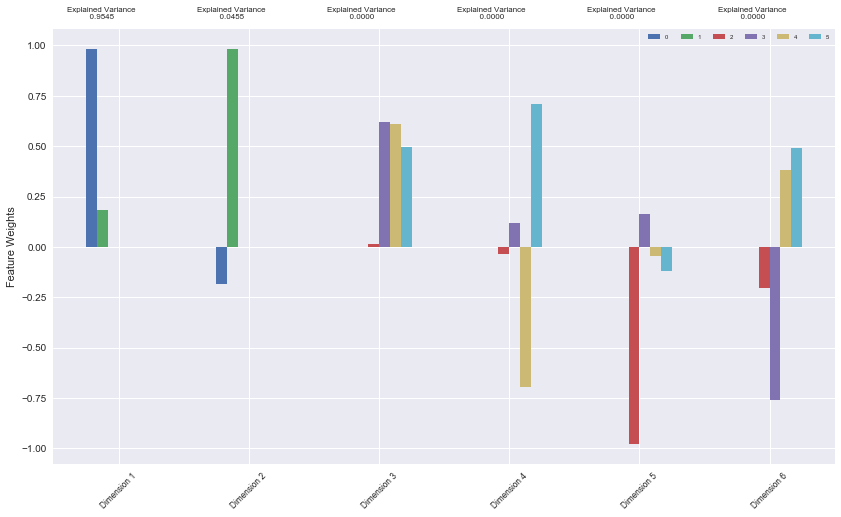

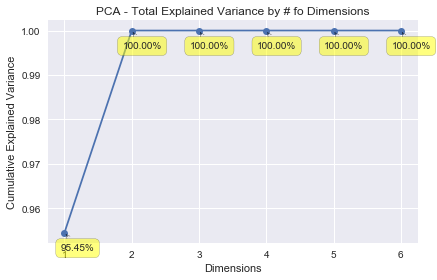

In [428]:
#let's do some visuzliation on pca
pca_results = vs.pca_results(train_annual_PCA, pca_annual)
plt.show()

ys = pca_annual.explained_variance_ratio_
xs = np.arange(1, len(ys) + 1)
plt.plot(xs, np.cumsum(ys), '-o')
for label, x, y in zip(np.cumsum(ys), xs, np.cumsum(ys)):
    plt.annotate('{:.2f}%'.format(label * 100),
        xy = (x, y), xytext = (30, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc='yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Dimensions')
plt.title('PCA - Total Explained Variance by # fo Dimensions')
plt.tight_layout()
plt.show()

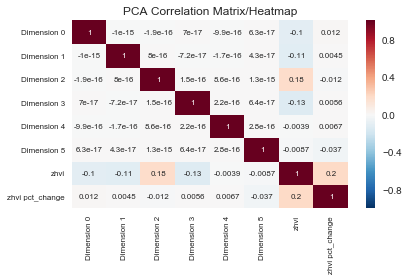

In [435]:
temp = pd.DataFrame.copy(train_annual_PCA)
temp.columns = ['Dimension ' + str(i) for i in range(6)]
temp['zhvi'] = ytrain1_annual
temp['zhvi pct_change'] = ytrain2_annual

g = sns.heatmap(temp.corr(), annot = True, annot_kws = {'size': 8})
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 8)
plt.title('PCA Correlation Matrix/Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi pct_change', 'N_MA pct_change', 'N_MA pct_change 1', 
                                                  'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi pct_change vs. NASDAQ pct_change' + zipcode)
    plt.tight_layout()
    plt.show()